In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.spatial.transform import Rotation
from astroquery.jplhorizons import Horizons
import astropy.units as u
from astropy.time import Time

import binascii
import collections
import gzip
import pathlib
import shutil
import string
import struct

from construct import *

import sys
sys.path.append('../Tianwen')

import ccsds

plt.rcParams['figure.figsize'] = (7, 3.5)
plt.rcParams['figure.facecolor'] = 'w'

In [2]:
frame_size = 1113

def load_frames(filename):
    frames = np.fromfile(filename, dtype='uint8')
    return frames[:frames.size//frame_size*frame_size].reshape(-1, frame_size)

In [3]:
TMPrimaryHeader = BitStruct(
    'transfer_frame_version_number' / BitsInteger(2),
    'spacecraft_id' / BitsInteger(10),
    'virtual_channel_id' / BitsInteger(3),
    'ocf_flag' / Flag,
    'master_channel_frame_count' / BitsInteger(8),
    'virtual_channel_frame_count' / BitsInteger(8),
    'secondary_header_flag' / Flag,
    'synch_flag' / Flag,
    'packet_order_flag' / Flag,
    'segment_length_id' / BitsInteger(2),
    'first_header_pointer' / BitsInteger(11)
)

TMFrame = Struct(
    'primary_header' / TMPrimaryHeader,
    'secondary_header' / Int64ub,
    'm_pdu_packet_zone' / Bytes(1099),
)

# https://max.rocketlabusa.com/docs#MAX/Command%20and%20Telemetry/Framing/Simple%20Frame.md
SimpleTelemetryFrame = Struct(
    'length' / Int32ul,
    'apid' / Int16ul,
    'seconds' / Int32ul,
    'subseconds' / Int16ul,
    'payload' / GreedyBytes,
)

Packet = Struct(
    'header' / ccsds.SpacePacketPrimaryHeader,
    'simple_frame' / SimpleTelemetryFrame,
)

In [4]:
files = ['escapade_blue_frames_2025_11_14_12_10.u8',
         'escapade_blue_frames_2025_11_14_16_49.u8',
         'escapade_gold_frames_2025_11_14_12_10.u8',
         'escapade_gold_frames_2025_11_14_16_49.u8',
        ]

In [5]:
spacecraft = ['blue', 'gold']
frames = {
    'blue': np.concatenate([load_frames(f) for f in files[:2]]),
    'gold': np.concatenate([load_frames(f) for f in files[2:4]]),
}

# TM frames

Frames are TM Space Data Link frames, using spacecraft ID `0x7b` for ESCAPADE-Blue `0x56` for ESCAPADE-Gold. These spacecraft IDs are not registered in SANA registry. The transmitters have a rather unusual feature: when there is no more data to send, rather than sending an only-idle-data frame, they retransmit the last frame. Only Virtual channel 2 is in use. There is no Operational Control Field, but there is a Frame Error Control Field (already stripped in GNU Radio). There is an 8 byte secondary header that does not conform to the CCSDS Blue Book (it does not have a Transfer Frame Secondary Header ID field that contains the Transfer Frame Secondary Header Length). The secondary header contains a 64-bit integer that has units of `1/2**16` seconds and uses the UNIX epoch.

In [6]:
duplicates = {sc: np.concatenate((np.zeros(1, 'bool'), np.all(frames[sc][1:] == frames[sc][:-1], axis=1)))
              for sc in spacecraft}
frames_no_dups = {sc: frames[sc][~duplicates[sc]] for sc in spacecraft}

In [7]:
tm = {sc: [TMFrame.parse(f) for f in frames[sc]] for sc in spacecraft}
scid = {sc: [a.primary_header.spacecraft_id for a in tm[sc]] for sc in spacecraft}
vcid = {sc: np.array([a.primary_header.virtual_channel_id for a in tm[sc]]) for sc in spacecraft}
mcfc = {sc: np.array([a.primary_header.master_channel_frame_count for a in tm[sc]]) for sc in spacecraft}
vcfc = {sc: np.array([a.primary_header.virtual_channel_frame_count for a in tm[sc]]) for sc in spacecraft}
timestamps = {sc: np.array([a.secondary_header for a in tm[sc]]) / 2**16 for sc in spacecraft}
timestamps = {sc: np.datetime64('1970-01-01T00:00:00') + np.round(1e9 * timestamps[sc]).astype('timedelta64[ns]')
    for sc in spacecraft}

In [8]:
[a.primary_header for a in tm['blue'][:10]]

[Container(transfer_frame_version_number=0, spacecraft_id=123, virtual_channel_id=2, ocf_flag=False, master_channel_frame_count=159, virtual_channel_frame_count=159, secondary_header_flag=True, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=6),
 Container(transfer_frame_version_number=0, spacecraft_id=123, virtual_channel_id=2, ocf_flag=False, master_channel_frame_count=159, virtual_channel_frame_count=159, secondary_header_flag=True, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=6),
 Container(transfer_frame_version_number=0, spacecraft_id=123, virtual_channel_id=2, ocf_flag=False, master_channel_frame_count=159, virtual_channel_frame_count=159, secondary_header_flag=True, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=6),
 Container(transfer_frame_version_number=0, spacecraft_id=123, virtual_channel_id=2, ocf_flag=False, master_channel_frame_count=159, virtual_channel_fr

In [9]:
[a.primary_header for a in tm['gold'][:10]]

[Container(transfer_frame_version_number=0, spacecraft_id=86, virtual_channel_id=2, ocf_flag=False, master_channel_frame_count=43, virtual_channel_frame_count=43, secondary_header_flag=True, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=207),
 Container(transfer_frame_version_number=0, spacecraft_id=86, virtual_channel_id=2, ocf_flag=False, master_channel_frame_count=44, virtual_channel_frame_count=44, secondary_header_flag=True, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=3),
 Container(transfer_frame_version_number=0, spacecraft_id=86, virtual_channel_id=2, ocf_flag=False, master_channel_frame_count=44, virtual_channel_frame_count=44, secondary_header_flag=True, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=3),
 Container(transfer_frame_version_number=0, spacecraft_id=86, virtual_channel_id=2, ocf_flag=False, master_channel_frame_count=46, virtual_channel_frame_count

In [10]:
def timestamp_axis():
    plt.xlabel('Secondary header timestamp')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.HourLocator())

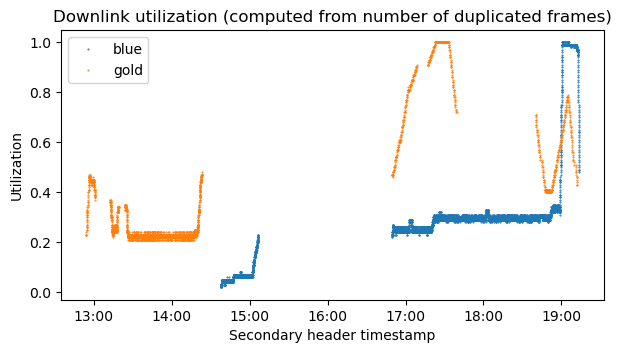

In [11]:
W = 100
for sc in spacecraft:
    plt.plot(timestamps[sc], np.convolve(np.ones(W)/W, ~duplicates[sc], mode='same'), '.', markersize=1, label=sc)
plt.legend()
plt.title('Downlink utilization (computed from number of duplicated frames)')
plt.ylabel('Utilization')
timestamp_axis()

In [12]:
{sc: collections.Counter(a.primary_header.transfer_frame_version_number for a in tm[sc]) for sc in spacecraft}

{'blue': Counter({0: 9154}), 'gold': Counter({0: 4148})}

In [13]:
{sc: collections.Counter(scid[sc]) for sc in spacecraft}

{'blue': Counter({123: 9154}), 'gold': Counter({86: 4148})}

In [14]:
hex(123), hex(86)

('0x7b', '0x56')

In [15]:
{sc: collections.Counter(vcid[sc]) for sc in spacecraft}

{'blue': Counter({np.int64(2): 9154}), 'gold': Counter({np.int64(2): 4148})}

In [16]:
{sc: collections.Counter(a.primary_header.secondary_header_flag for a in tm[sc]) for sc in spacecraft}

{'blue': Counter({True: 9154}), 'gold': Counter({True: 4148})}

In [17]:
mcfc_unwrap = {sc: np.empty(frames[sc].shape[0], 'int') for sc in spacecraft}
for sc in spacecraft:
    last = 0
    for j in range(frames[sc].shape[0]):
        mcfc_unwrap[sc][j] = (mcfc[sc][j] + (last // 256) * 256
                          if last % 256 <= mcfc[sc][j]
                          else mcfc[sc][j] + (last // 256 + 1) * 256)
        last = mcfc_unwrap[sc][j]

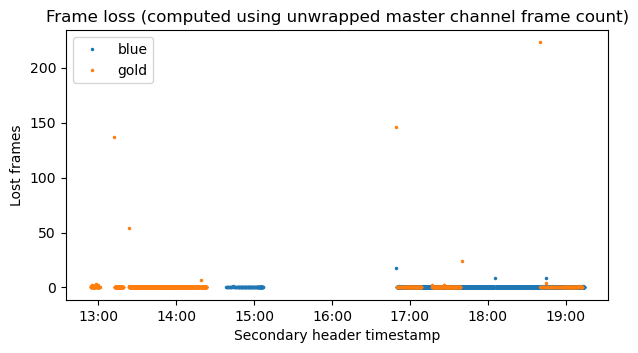

In [18]:
for sc in spacecraft:
    plt.plot(timestamps[sc][~duplicates[sc]][1:], np.diff(mcfc_unwrap[sc][~duplicates[sc]])-1, '.', markersize=3, label=sc)
plt.legend()
plt.title('Frame loss (computed using unwrapped master channel frame count)')
plt.ylabel('Lost frames')
timestamp_axis()

# VC2

Virtual channel 2 contains CCSDS Space Packets. The only APID in use is 51. The packet payloads contain [MAX simple telemetry frames](https://max.rocketlabusa.com/docs#MAX/Command%20and%20Telemetry/Framing/Simple%20Frame.md), which also has its own concept of APID. Many different APIDs are in use.

In [19]:
scid_sc = {'blue': 0x7b, 'gold': 0x56}
packets = {sc: list(ccsds.extract_space_packets([t for t, dup in zip(tm[sc], duplicates[sc]) if not dup], scid_sc[sc], 2))
           for sc in spacecraft}

/home/daniel/contracting/ESCAPADE/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 123 VC 2] Broken stream. Last frame count 170, current frame count 172
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/contracting/ESCAPADE/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 123 VC 2] Broken stream. Last frame count 12, current frame count 31
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/contracting/ESCAPADE/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 123 VC 2] Broken stream. Last frame count 54, current frame count 56
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new

In [20]:
def try_parse_packet(p):
    try:
        return Packet.parse(p)
    except Exception:
        print(f'failed to parse packet {p}')

packets = {sc: [parsed for p in packets[sc] if (parsed := try_parse_packet(p)) is not None]
                for sc in spacecraft}

headers = {sc: [p.header for p in packets[sc]] for sc in spacecraft}

failed to parse packet b'\x004\xec\n\x00\t\x00\x00\x00\xdb\x18\x00\x00\x00\x00\x0f'
failed to parse packet b'\x00\x10\x00\x00\x00\x01\x11]'


In [21]:
headers['blue'][:10]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=51, sequence_flags=3, packet_sequence_count_or_name=0, data_length=251),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=51, sequence_flags=3, packet_sequence_count_or_name=0, data_length=191),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=51, sequence_flags=3, packet_sequence_count_or_name=0, data_length=614),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=51, sequence_flags=3, packet_sequence_count_or_name=0, data_length=65),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=51, sequence_flags=3, packet_sequence_count_or_name=0, data_length=614),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=51, sequence_flags=3, packet_sequence_count_or_name=0, data_length=614),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=51, sequence_flags=3, pa

In [22]:
headers['gold'][:10]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=51, sequence_flags=3, packet_sequence_count_or_name=0, data_length=75),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=51, sequence_flags=3, packet_sequence_count_or_name=0, data_length=79),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=51, sequence_flags=3, packet_sequence_count_or_name=0, data_length=99),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=51, sequence_flags=3, packet_sequence_count_or_name=0, data_length=614),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=51, sequence_flags=3, packet_sequence_count_or_name=0, data_length=67),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=51, sequence_flags=3, packet_sequence_count_or_name=0, data_length=267),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=51, sequence_flags=3, packe

In [23]:
{sc: collections.Counter([p.APID for p in headers[sc]]) for sc in spacecraft}

{'blue': Counter({51: 12977}), 'gold': Counter({51: 6297})}

In [24]:
{sc: collections.Counter([p.secondary_header_flag for p in headers[sc]]) for sc in spacecraft}

{'blue': Counter({False: 12977}), 'gold': Counter({False: 6297})}

In [25]:
{sc: collections.Counter([p.data_length for p in headers[sc]]) for sc in spacecraft}

{'blue': Counter({227: 2690,
          75: 1677,
          107: 1673,
          459: 1501,
          24: 836,
          79: 834,
          99: 834,
          91: 814,
          614: 680,
          1093: 521,
          191: 206,
          397: 205,
          63: 135,
          179: 130,
          84: 28,
          94: 25,
          159: 23,
          85: 16,
          74: 14,
          140: 14,
          76: 12,
          120: 9,
          77: 8,
          39: 6,
          51: 4,
          44: 4,
          45: 4,
          93: 4,
          60: 3,
          97: 3,
          46: 3,
          87: 3,
          101: 2,
          49: 2,
          53: 2,
          59: 2,
          89: 2,
          171: 2,
          43: 2,
          251: 1,
          65: 1,
          52: 1,
          50: 1,
          62: 1,
          103: 1,
          131: 1,
          118: 1,
          82: 1,
          58: 1,
          160: 1,
          175: 1,
          83: 1,
          203: 1,
          128: 1,
          92:

In [26]:
for sc in spacecraft:
    for p in packets[sc]:
        assert p.simple_frame.length == len(p.simple_frame.payload) + 8

In [27]:
packet_timestamps = {sc: [
    np.datetime64('1970-01-01T00:00:00')
    + np.round(1e9 * (p.simple_frame.seconds + p.simple_frame.subseconds / 40000)).astype('timedelta64[ns]')
    for p in packets[sc]] for sc in spacecraft}                   

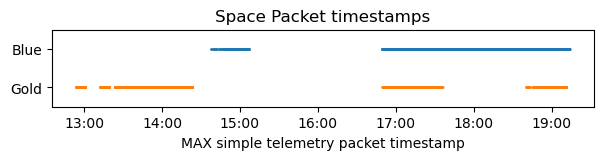

In [28]:
plt.figure(figsize=(7, 1))
for n, sc in enumerate(spacecraft):
    plt.plot(packet_timestamps[sc], [1 - n] * len(packet_timestamps[sc]), '.', markersize=1)
timestamp_axis()
plt.xlabel('MAX simple telemetry packet timestamp')
plt.yticks([1, 0], ['Blue', 'Gold'])
plt.ylim([-0.5, 1.5])
plt.title('Space Packet timestamps');

In [29]:
{sc: collections.Counter([p.simple_frame.apid for p in packets[sc]]) for sc in spacecraft}

{'blue': Counter({620: 917,
          621: 915,
          622: 858,
          6074: 837,
          6075: 836,
          6084: 836,
          7612: 836,
          6085: 835,
          6363: 834,
          6423: 834,
          5121: 831,
          2220: 810,
          7600: 680,
          5141: 670,
          740: 566,
          4002: 206,
          520: 205,
          4000: 205,
          1020: 135,
          730: 130,
          7711: 1}),
 'gold': Counter({7600: 733,
          5141: 510,
          520: 437,
          6082: 428,
          6081: 427,
          7633: 424,
          5121: 229,
          6085: 214,
          6363: 214,
          6423: 213,
          7732: 213,
          7612: 213,
          7753: 213,
          6074: 212,
          6075: 212,
          2220: 211,
          6084: 211,
          620: 106,
          621: 106,
          623: 105,
          624: 105,
          40007: 104,
          7738: 104,
          622: 104,
          4000: 98,
          4002: 97,
          

In [30]:
all_apids = sorted({p.simple_frame.apid for sc in spacecraft for p in packets[sc]})
apid_timestamps  = {sc: {apid: (np.datetime64('1970-01-01T00:00:00')
    + np.array([np.round(1e9 * (p.simple_frame.seconds + p.simple_frame.subseconds / 40000)).astype('timedelta64[ns]')
                for p in packets[sc] if p.simple_frame.apid == apid])) for apid in {p.simple_frame.apid for p in packets[sc]}}
             for sc in spacecraft}

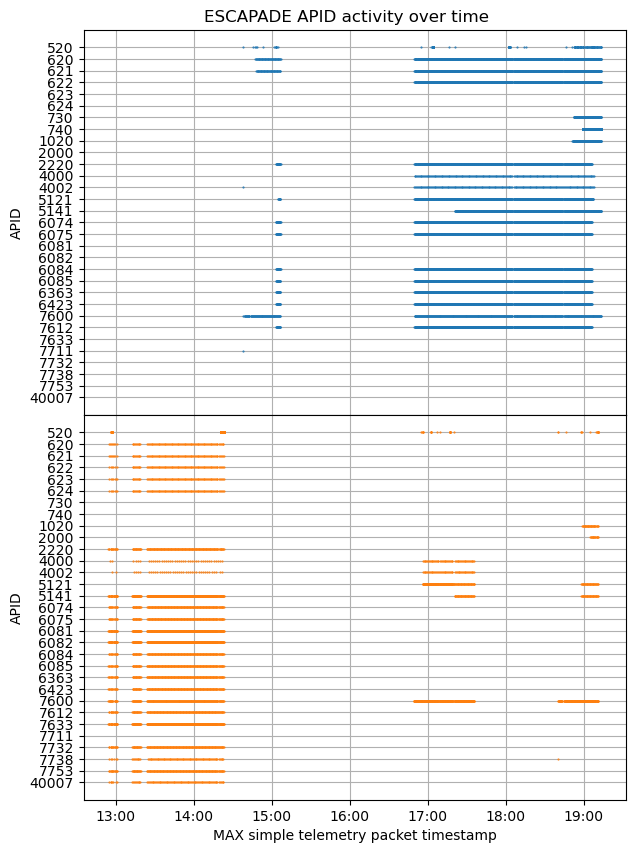

In [31]:
fig, axs = plt.subplots(2, 1, figsize=(7, 10), sharex=True, sharey=True)
for j, sc in enumerate(spacecraft):
    for k, apid in enumerate(all_apids):
        if apid in apid_timestamps[sc]:
            ts = apid_timestamps[sc][apid]
            axs[j].plot(ts, len(ts) * [-k], '.', color=f'C{j}', markersize=1)
    axs[j].set_yticks(-np.arange(len(all_apids)), [str(a) for a in all_apids])
    axs[j].grid()
    axs[j].set_ylabel('APID')
plt.subplots_adjust(hspace=0)
timestamp_axis()
plt.xlabel('MAX simple telemetry packet timestamp')
plt.suptitle('ESCAPADE APID activity over time', y=0.9);

In [32]:
def payloads_by_apid(sc, apid):
    return [p.simple_frame.payload for p in packets[sc] if p.simple_frame.apid == apid]

def array_by_apid(sc, apid):
    return np.array([np.frombuffer(p, 'uint8') for p in payloads_by_apid(sc, apid)])

def plot_apid(sc, apid, *, vmax=255):
    plt.figure(figsize=(10, 4))
    plt.imshow(array_by_apid(sc, apid),
               aspect='auto', interpolation='None', vmin=0, vmax=vmax)
    plt.title(f'ESCAPADE {sc} APID {apid}')
    plt.ylabel('Packet number')
    plt.xlabel('Payload byte number')

In [33]:
for sc in spacecraft:
    for apid in {p.simple_frame.apid for p in packets[sc]}:
        if apid in [520, 740]:
            continue
        ps = payloads_by_apid(sc, apid)
        for p in ps:
            assert len(p) == len(ps[0])

In [34]:
payloads_by_apid('blue', 520)

[b'\xc0\x00\x00/,\x00\x00\x00\x08\x02\xc9>\x17iE\x11E_INFO: set_tm_tf_size: End sequence\x003',
 b'E_CMD_HIST: [ OK  ] CDH_NOOP',
 b'E_CMD_HIST: [ OK  ] MISC_CONFIG_PARSE, String: tlm_master.set_apid_freq(620, 0.05);',
 b'E_CMD_HIST: [ OK  ] MISC_CONFIG_PARSE, String: tlm_master.set_apid_freq(621, 0.05);',
 b'E_CMD_HIST: [ OK  ] FJ_ABORT, Proc: CommsFallback',
 b'E_CMD_HIST: [ OK  ] FJ_START_ABS, Time: 1763146080.000000, File: CommsFallback, Args: ',
 b'E_CMD_HIST: [ OK  ] CDH_NOOP',
 b'E_CMD_HIST: [ OK  ] MISC_CONFIG_PARSE, String: tlm_master.set_apid_freq(2220, 0.1);',
 b'E_CMD_HIST: [ OK  ] MISC_CONFIG_PARSE, String: tlm_master.set_apid_freq(6074, 0.1);',
 b'E_CMD_HIST: [ OK  ] MISC_CONFIG_PARSE, String: tlm_master.set_apid_freq(6075, 0.1);',
 b'E_CMD_HIST: [ OK  ] MISC_CONFIG_PARSE, String: tlm_master.set_apid_freq(6084, 0.1);',
 b'E_CMD_HIST: [ OK  ] MISC_CONFIG_PARSE, String: tlm_master.set_apid_freq(6085, 0.1);',
 b'E_CMD_HIST: [ OK  ] MISC_CONFIG_PARSE, String: tlm_master.set_a

In [35]:
for t, msg in zip(apid_timestamps['blue'][520], payloads_by_apid('blue', 520)):
    try:
        print(str(t)[len('2025-11-14T'):-len('.613074944')], str(msg, encoding='ascii'))
    except UnicodeDecodeError:
        pass

14:45:47 E_CMD_HIST: [ OK  ] CDH_NOOP
14:47:21 E_CMD_HIST: [ OK  ] MISC_CONFIG_PARSE, String: tlm_master.set_apid_freq(620, 0.05);
14:47:56 E_CMD_HIST: [ OK  ] MISC_CONFIG_PARSE, String: tlm_master.set_apid_freq(621, 0.05);
14:48:39 E_CMD_HIST: [ OK  ] FJ_ABORT, Proc: CommsFallback
14:52:49 E_CMD_HIST: [ OK  ] FJ_START_ABS, Time: 1763146080.000000, File: CommsFallback, Args: 
15:01:57 E_CMD_HIST: [ OK  ] CDH_NOOP
15:03:11 E_CMD_HIST: [ OK  ] MISC_CONFIG_PARSE, String: tlm_master.set_apid_freq(2220, 0.1);
15:03:12 E_CMD_HIST: [ OK  ] MISC_CONFIG_PARSE, String: tlm_master.set_apid_freq(6074, 0.1);
15:03:12 E_CMD_HIST: [ OK  ] MISC_CONFIG_PARSE, String: tlm_master.set_apid_freq(6075, 0.1);
15:03:12 E_CMD_HIST: [ OK  ] MISC_CONFIG_PARSE, String: tlm_master.set_apid_freq(6084, 0.1);
15:03:13 E_CMD_HIST: [ OK  ] MISC_CONFIG_PARSE, String: tlm_master.set_apid_freq(6085, 0.1);
15:03:13 E_CMD_HIST: [ OK  ] MISC_CONFIG_PARSE, String: tlm_master.set_apid_freq(6363, 0.1);
15:03:13 E_CMD_HIST: [ OK

In [36]:
payloads_by_apid('gold', 520)

[b'E_INFO: DisableComponents: Begin sequence',
 b'E_INFO: DisableComponents: Disabling STA',
 b'E_CMD_HIST: [ OK  ] AOCS_ST_A_POWER Value=[False]',
 b'E_INFO: set_st_power_state: Begin sequence',
 b'E_CMD_HIST: [ OK  ] EPS_SPOC_DIO_ST_A_PWR_EN ENABLE_STATE=[0, Off]',
 b'E_CMD_HIST: [ OK  ] CDH_SPOC_IO_GPIO_STATE_SET IDX=[110] STATE=[0, E_Low]',
 b'E_CMD_HIST: [ OK  ] EPS_SPOC_DIO_ST_A_PWR_EN ENABLE_STATE=[0, Off]',
 b'E_CMD_HIST: [ OK  ] CDH_SPOC_IO_GPIO_STATE_SET IDX=[110] STATE=[0, E_Low]',
 b'E_CMD_HIST: [ OK  ] EPS_SPOC_DIO_ST_A_PWR_EN ENABLE_STATE=[0, Off]',
 b'E_CMD_HIST: [ OK  ] CDH_SPOC_IO_GPIO_STATE_SET IDX=[110] STATE=[0, E_Low]',
 b'E_CMD_HIST: [ OK  ] EPS_SPOC_DIO_ST_B_PWR_EN ENABLE_STATE=[0, Off]',
 b'E_CMD_HIST: [ OK  ] CDH_SPOC_IO_GPIO_STATE_SET IDX=[111] STATE=[0, E_Low]',
 b'E_CMD_HIST: [ OK  ] EPS_SPOC_DIO_ST_B_PWR_EN ENABLE_STATE=[0, Off]',
 b'E_CMD_HIST: [ OK  ] CDH_SPOC_IO_GPIO_STATE_SET IDX=[111] STATE=[0, E_Low]',
 b'E_CMD_HIST: [ OK  ] EPS_SPOC_DIO_ST_OCP_EN ENA

In [37]:
for t, msg in zip(apid_timestamps['gold'][520], payloads_by_apid('gold', 520)):
    try:
        print(str(t)[len('2025-11-14T'):-len('.613074944')], str(msg, encoding='ascii'))
    except UnicodeDecodeError:
        pass

12:56:32 E_INFO: DisableComponents: Begin sequence
12:56:32 E_INFO: DisableComponents: Disabling STA
12:56:32 E_CMD_HIST: [ OK  ] AOCS_ST_A_POWER Value=[False]
12:56:33 E_INFO: set_st_power_state: Begin sequence
12:56:33 E_CMD_HIST: [ OK  ] EPS_SPOC_DIO_ST_A_PWR_EN ENABLE_STATE=[0, Off]
12:56:33 E_CMD_HIST: [ OK  ] CDH_SPOC_IO_GPIO_STATE_SET IDX=[110] STATE=[0, E_Low]
12:56:33 E_CMD_HIST: [ OK  ] EPS_SPOC_DIO_ST_A_PWR_EN ENABLE_STATE=[0, Off]
12:56:33 E_CMD_HIST: [ OK  ] CDH_SPOC_IO_GPIO_STATE_SET IDX=[110] STATE=[0, E_Low]
12:56:34 E_CMD_HIST: [ OK  ] EPS_SPOC_DIO_ST_A_PWR_EN ENABLE_STATE=[0, Off]
12:56:34 E_CMD_HIST: [ OK  ] CDH_SPOC_IO_GPIO_STATE_SET IDX=[110] STATE=[0, E_Low]
12:56:34 E_CMD_HIST: [ OK  ] EPS_SPOC_DIO_ST_B_PWR_EN ENABLE_STATE=[0, Off]
12:56:34 E_CMD_HIST: [ OK  ] CDH_SPOC_IO_GPIO_STATE_SET IDX=[111] STATE=[0, E_Low]
12:56:35 E_CMD_HIST: [ OK  ] EPS_SPOC_DIO_ST_B_PWR_EN ENABLE_STATE=[0, Off]
12:56:35 E_CMD_HIST: [ OK  ] CDH_SPOC_IO_GPIO_STATE_SET IDX=[111] STATE=[0, 

In [38]:
payloads_by_apid('blue', 620)

[b'CommsFallback\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00CommsFallback\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00EXPR\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x07\x00\x00\x00\x01\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00D\x00\x00\x00\x00\x00\x00\x00',
 b'CommsFallback\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00Com

In [39]:
payloads_by_apid('gold', 620)

[b'CommsFallback\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00CommsFallback\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00EXPR\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x07\x00\x00\x00\x01\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00C\x00\x00\x00\x00\x00\x00\x00',
 b'CommsFallback\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00Com

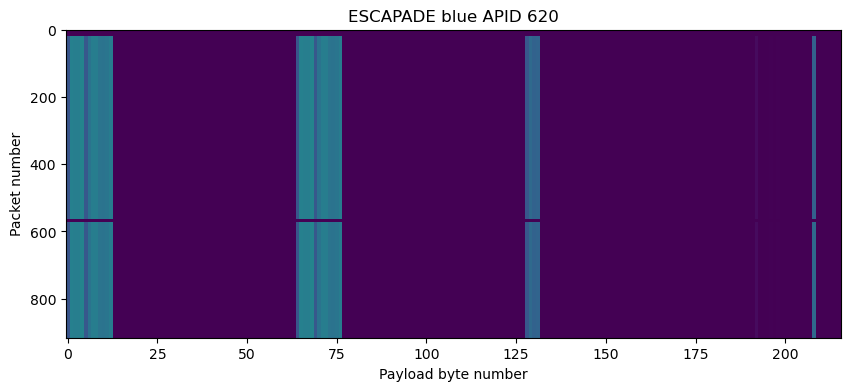

In [40]:
plot_apid('blue', 620)

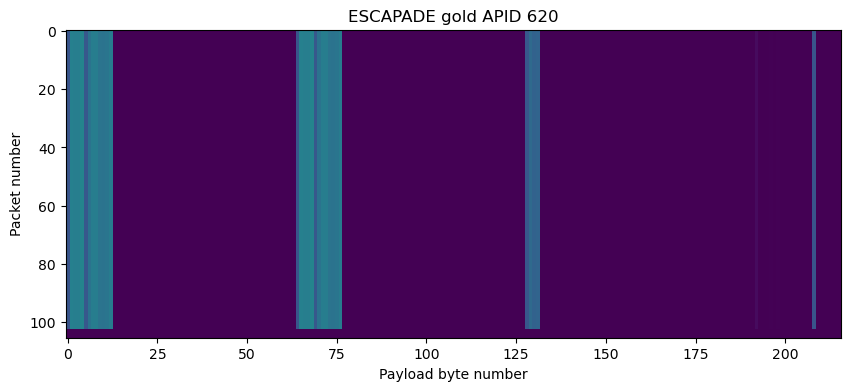

In [41]:
plot_apid('gold', 620)

In [42]:
payloads_by_apid('blue', 621)

[b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00',
 b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0

In [43]:
payloads_by_apid('gold', 621)

[b'DisableComponents\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00DisableComponents\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00EXPR\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x07\x00\x00\x00\x01\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00J\x00\x00\x00\x00\x00\x00\x00',
 b'DisableComponents\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00DisableComponents\x00\x00\x00\x00\x00\x

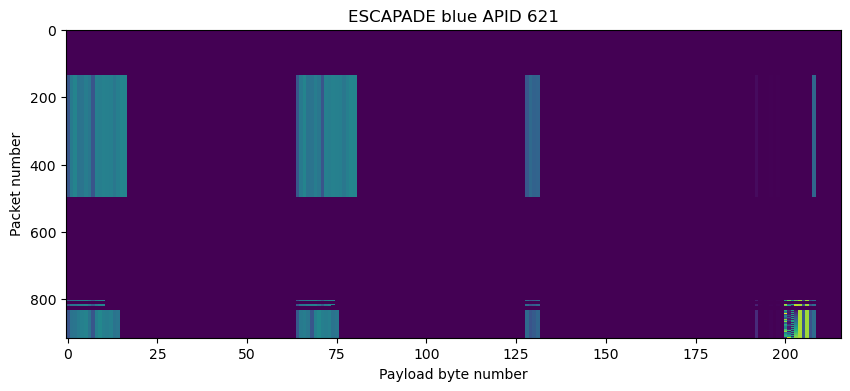

In [44]:
plot_apid('blue', 621)

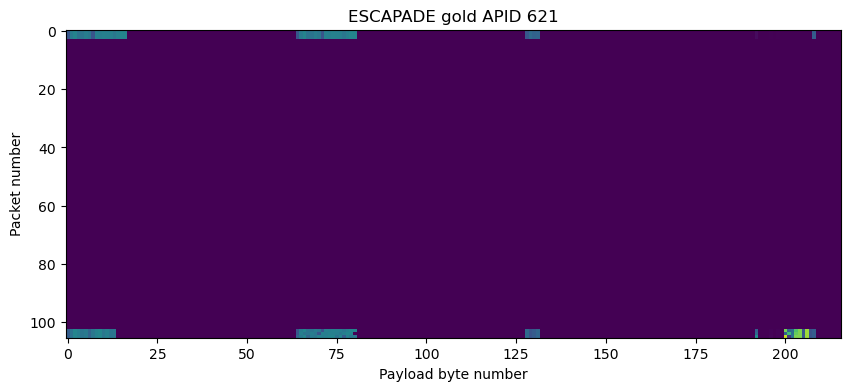

In [45]:
plot_apid('gold', 621)

In [46]:
payloads_by_apid('blue', 622)

[b'ConfigureRadioInternal\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00ConfigureRadioInternal\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00WAIT_UNTIL\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00/\x00\x00\x00\x01\x00\x02\x00r\xf9"h\xd7E\xdaAJ\x00\x00\x00\x00\x00\x00\x00',
 b'ConfigureRadioInternal\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00ConfigureRadioInternal\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x

In [47]:
payloads_by_apid('gold', 622)

[b'ConfigureRadioInternal\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00ConfigureRadioInternal\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00WAIT_UNTIL\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00/\x00\x00\x00\x01\x00\x02\x00&SR\xa5\xc9E\xdaA,\x00\x00\x00\x00\x00\x00\x00',
 b'ConfigureRadioInternal\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00ConfigureRadioInternal\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x

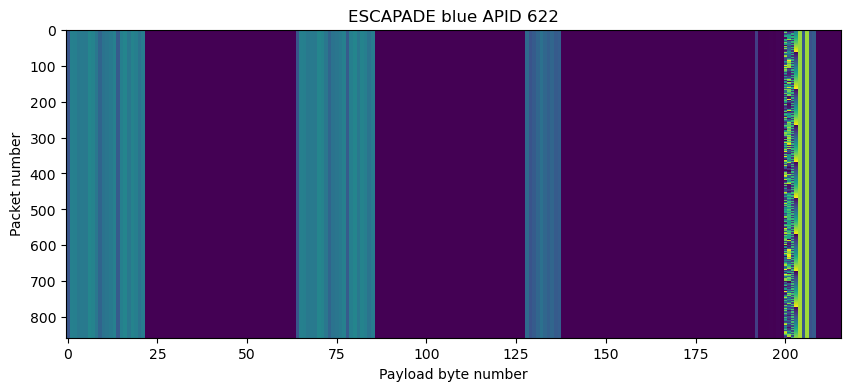

In [48]:
plot_apid('blue', 622)

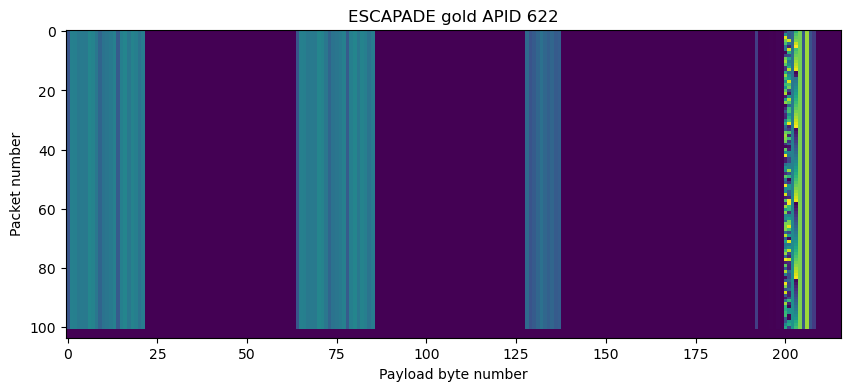

In [49]:
plot_apid('gold', 622)

In [50]:
payloads_by_apid('gold', 623)

[b'FWReset\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00FWReset\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00WAIT_UNTIL\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x16\x00\x00\x00\x01\x00\x02\x00\rql\xa5\xc9E\xdaA.\x00\x00\x00\x00\x00\x00\x00',
 b'FWReset\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\

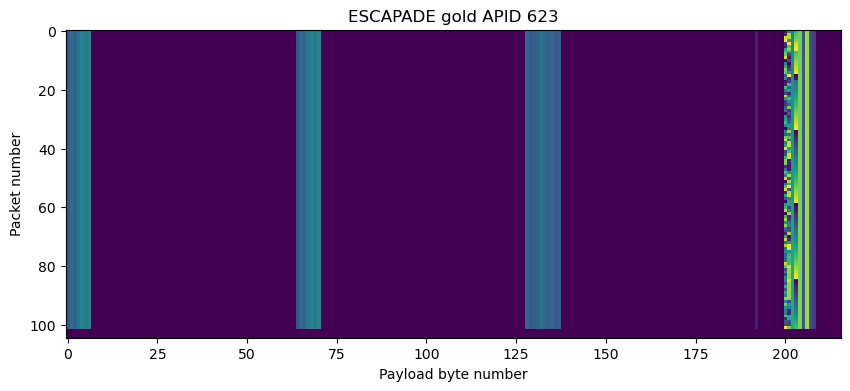

In [51]:
plot_apid('gold', 623)

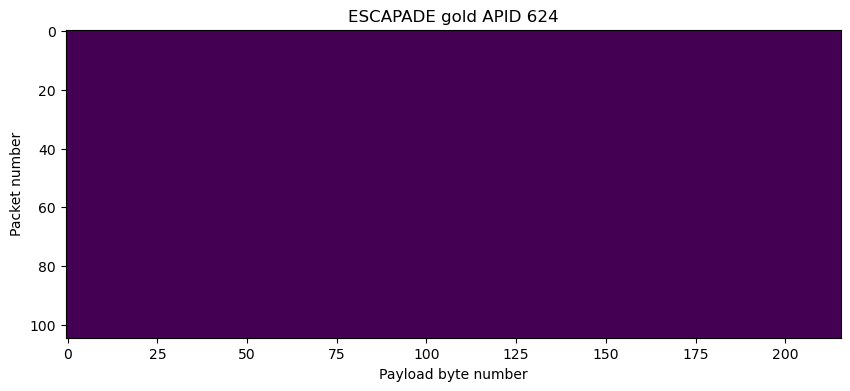

In [52]:
plot_apid('gold', 624)

In [53]:
payloads_by_apid('blue', 730)

[b'/mnt/mmc0/logs/compton/inv_sts/inv_sts-1763132730.mtc.gz\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0c\xd3P#\x00\x00\x00\x00\x03\x00\x00\x00\xa4\x0f\x00\x00\x04\x00\x00\x00\x96\xd8\xc1\xf2\x03\x00\x00\x00\x00\x00\x00\x004\x00\x00\x00\xdc\xaa\x16\x00',
 b'/mnt/mmc0/logs/compton/inv_sts/inv_sts-1763132730.mtc.gz\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0c\xd3P#\x00\x00\x00\x00\x03\x00\x00\x00\xa4\x0f\x00\x00\x04\x00\x00\x00\x96\xd8\xc1\xf2\x03\x00\x00\x00\x00\x00\x00\x004\x00\x00\x00\xdc\xaa\x16\x00'

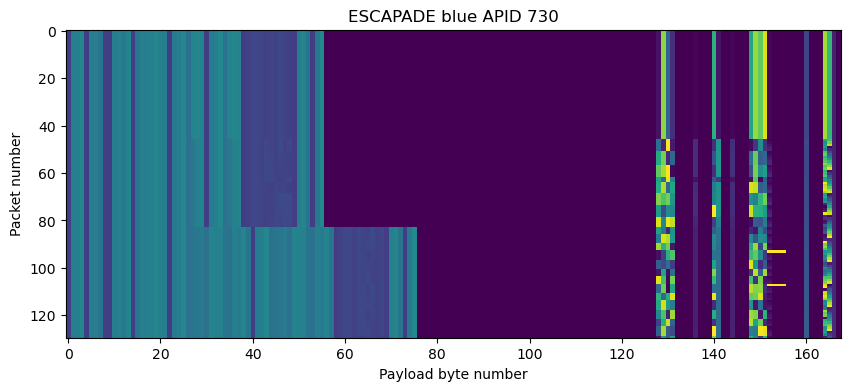

In [54]:
plot_apid('blue', 730)

In [55]:
def parse_file_downlink(sc, output_directory):
    file_downlink = payloads_by_apid(sc, 740)    
    ident = None
    discontinuity = False
    for file_packet in file_downlink:
        last_ident = ident
        packet_type, ident = struct.unpack('<2I', file_packet[:8])
        if packet_type == 0:
            # file declaration
            assert last_ident is None or discontinuity
            file_size, num_chunks, crc = struct.unpack('<3I', file_packet[8:20])
            file_path = file_packet[20:]
            file_path = str(file_path[:file_path.index(b'\x00')], encoding='ascii')
            print(f'[{ident:08x}] file declaration: size = {file_size}, chunks = {num_chunks}, crc = 0x{crc:08x}, path = {file_path}')
            file_data = b''
            last_chunk_seq = -1
            discontinuity = False
        elif packet_type == 1:
            # file chunk
            assert ident == last_ident
            chunk_seq, chunk_offset, payload_len = struct.unpack('<3I', file_packet[8:20])
            payload = file_packet[20:]
            assert len(payload) == payload_len
            print(f'[{ident:08x}] file chunk: seq = {chunk_seq}, offset = {chunk_offset}, payload size = {payload_len}')
            if discontinuity:
                continue
            if chunk_seq != last_chunk_seq + 1:
                print('DISCONTINUITY')
                discontinuity = True
                continue
            assert chunk_seq < num_chunks
            last_chunk_seq = chunk_seq
            assert len(file_data) == chunk_offset
            file_data += payload
            if len(file_data) == file_size:
                assert chunk_seq == num_chunks - 1
                assert binascii.crc32(file_data) == crc
                filename = file_path[1:].replace('/', '+')
                if filename.endswith('.gz'):
                    # decompress
                    file_data = gzip.decompress(file_data)
                    filename = filename[:-3]  # strip .gz extension
                with open(output_directory / filename, 'wb') as f:
                    f.write(file_data)
                ident = None

In [56]:
for sc in ['blue', 'gold']:
    output_directory = pathlib.Path(f'downlink-files-{sc}')
    shutil.rmtree(output_directory)
    output_directory.mkdir()
    print(f'File downlink for {sc}')
    parse_file_downlink(sc, output_directory)
    print()

File downlink for blue
[c9f119d2] file declaration: size = 407, chunks = 1, crc = 0xf00a0b61, path = /tmp/BackorbDownload.gz
[c9f119d2] file chunk: seq = 0, offset = 0, payload size = 407
[12fd1a5b] file declaration: size = 34850, chunks = 33, crc = 0x257d2907, path = /mnt/mmc0/logs/compton/inv_eps/inv_eps-1762741927.mtc.gz
[12fd1a5b] file chunk: seq = 0, offset = 0, payload size = 1062
[12fd1a5b] file chunk: seq = 1, offset = 1062, payload size = 1062
[12fd1a5b] file chunk: seq = 2, offset = 2124, payload size = 1062
[12fd1a5b] file chunk: seq = 3, offset = 3186, payload size = 1062
[12fd1a5b] file chunk: seq = 4, offset = 4248, payload size = 1062
[12fd1a5b] file chunk: seq = 5, offset = 5310, payload size = 1062
[12fd1a5b] file chunk: seq = 6, offset = 6372, payload size = 1062
[12fd1a5b] file chunk: seq = 7, offset = 7434, payload size = 1062
[12fd1a5b] file chunk: seq = 8, offset = 8496, payload size = 1062
[12fd1a5b] file chunk: seq = 9, offset = 9558, payload size = 1062
[12fd1a

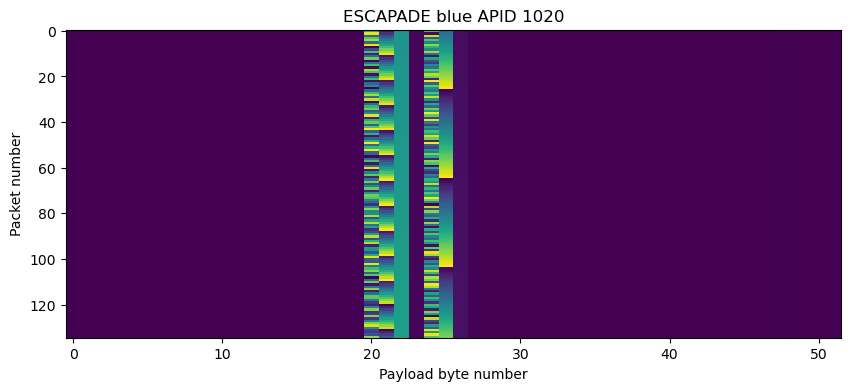

In [57]:
plot_apid('blue', 1020)

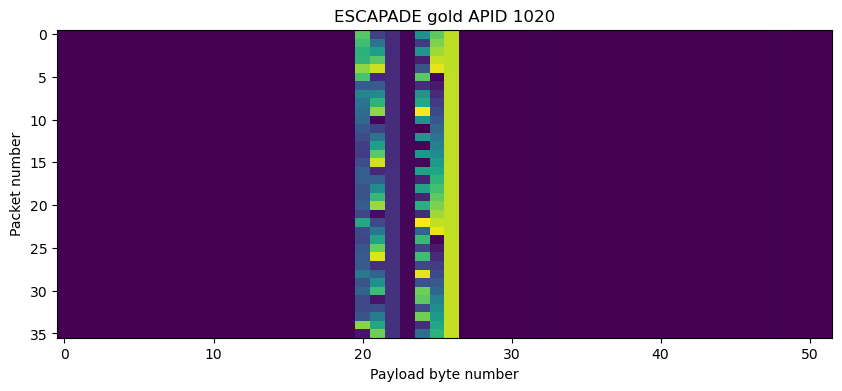

In [58]:
plot_apid('gold', 1020)

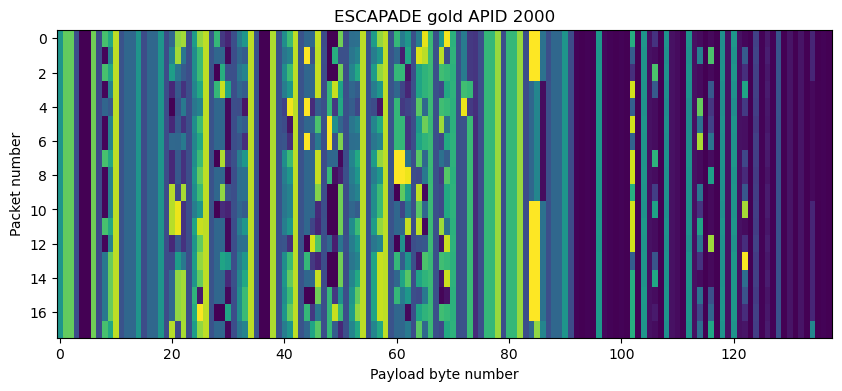

In [59]:
plot_apid('gold', 2000)

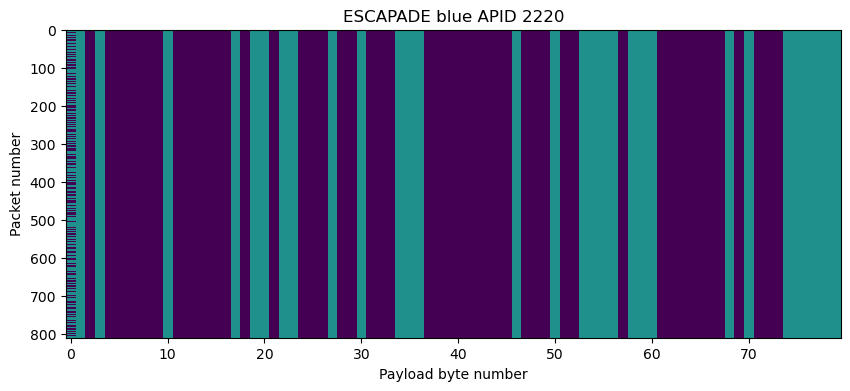

In [60]:
plot_apid('blue', 2220, vmax=2)

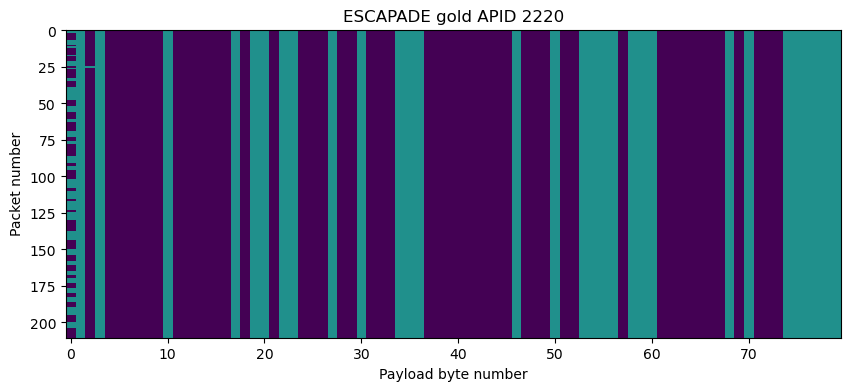

In [61]:
plot_apid('gold', 2220, vmax=2)

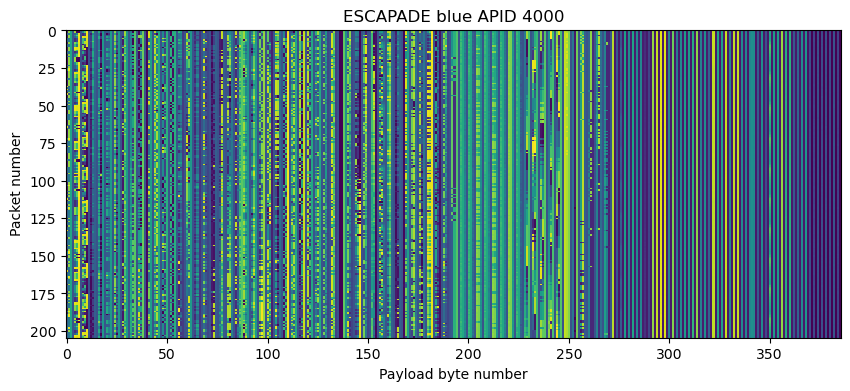

In [62]:
plot_apid('blue', 4000)

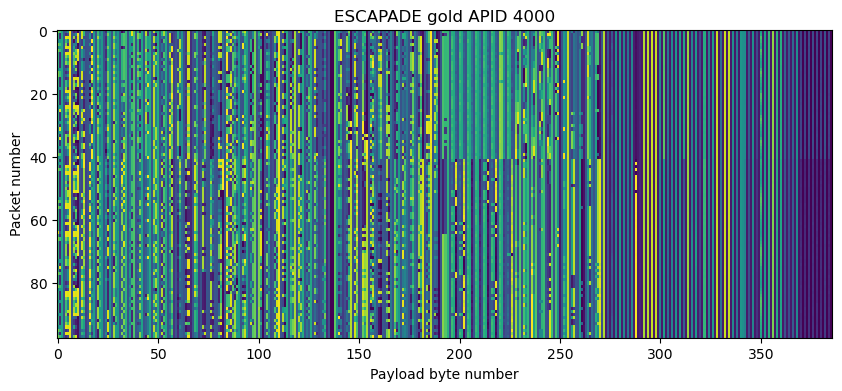

In [63]:
plot_apid('gold', 4000)

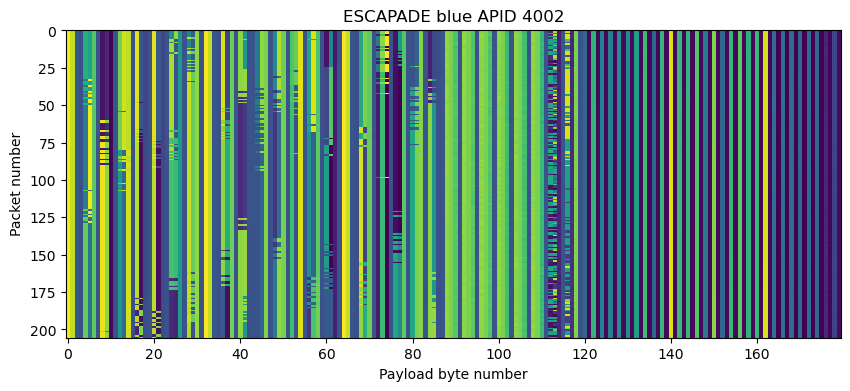

In [64]:
plot_apid('blue', 4002)

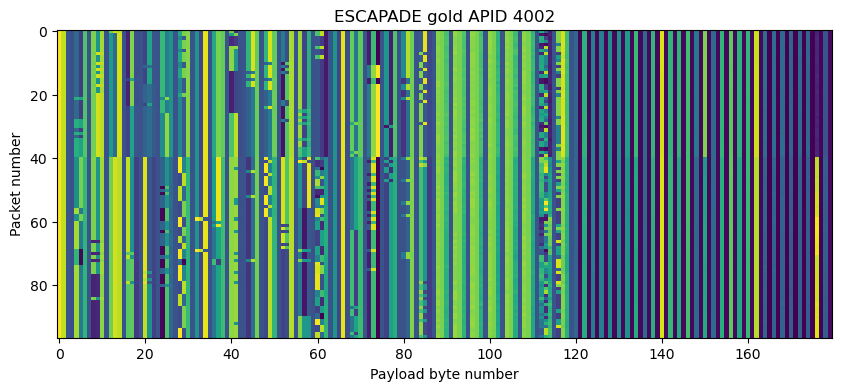

In [65]:
plot_apid('gold', 4002)

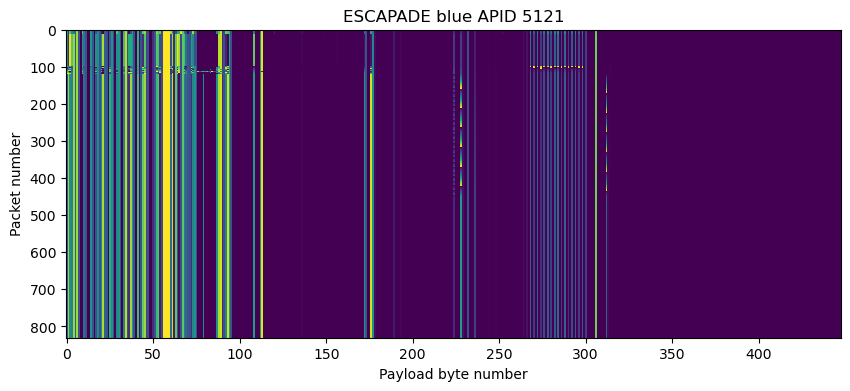

In [66]:
plot_apid('blue', 5121)

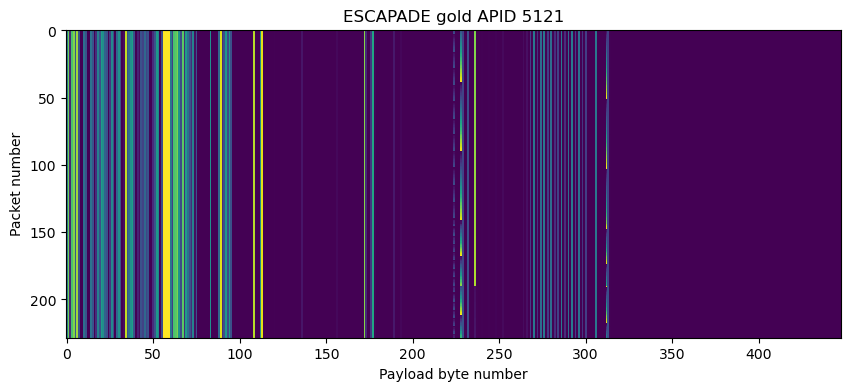

In [67]:
plot_apid('gold', 5121)

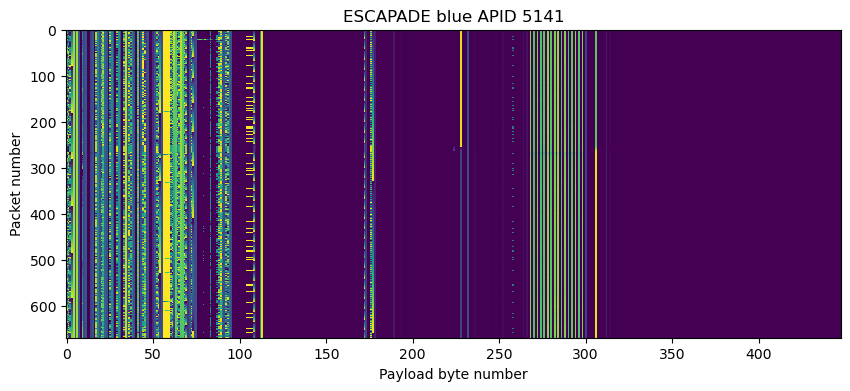

In [68]:
plot_apid('blue', 5141)

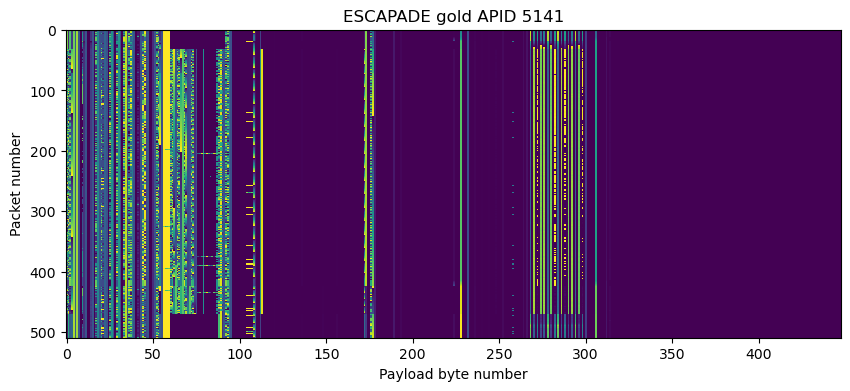

In [69]:
plot_apid('gold', 5141)

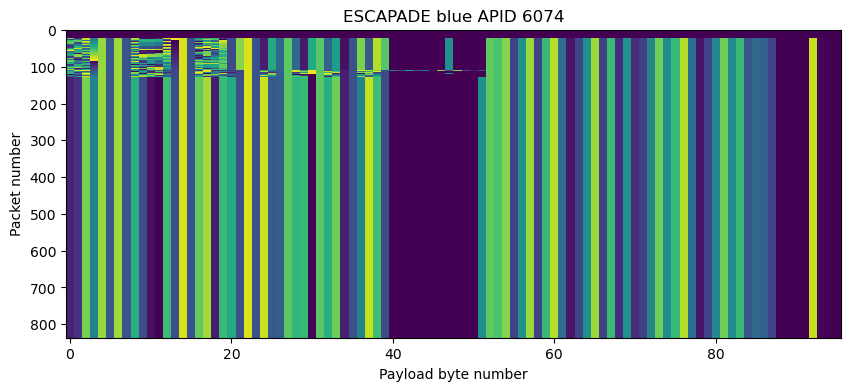

In [70]:
plot_apid('blue', 6074)

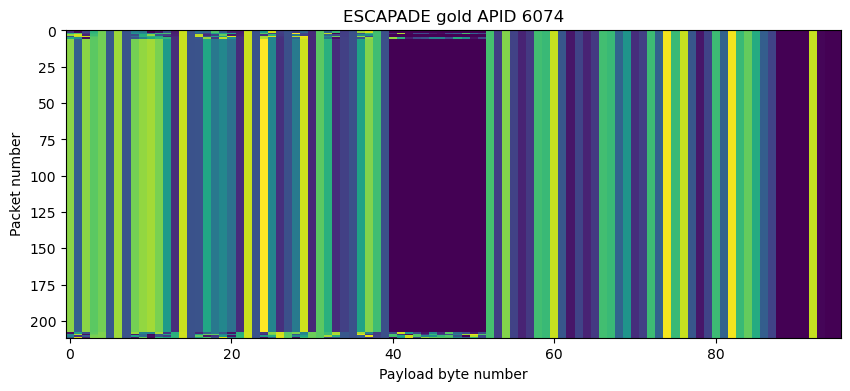

In [71]:
plot_apid('gold', 6074)

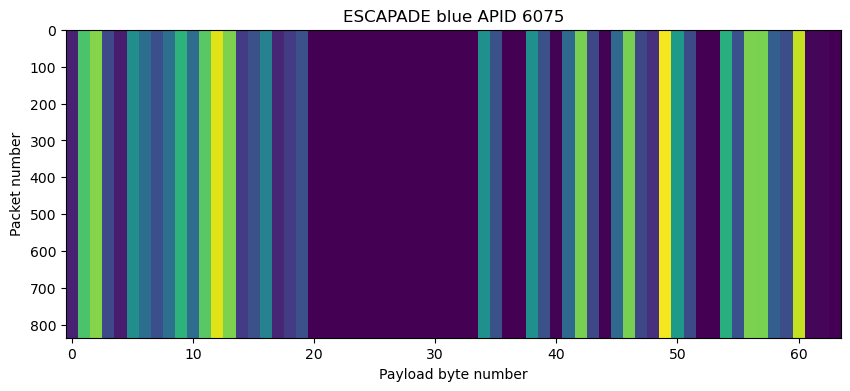

In [72]:
plot_apid('blue', 6075)

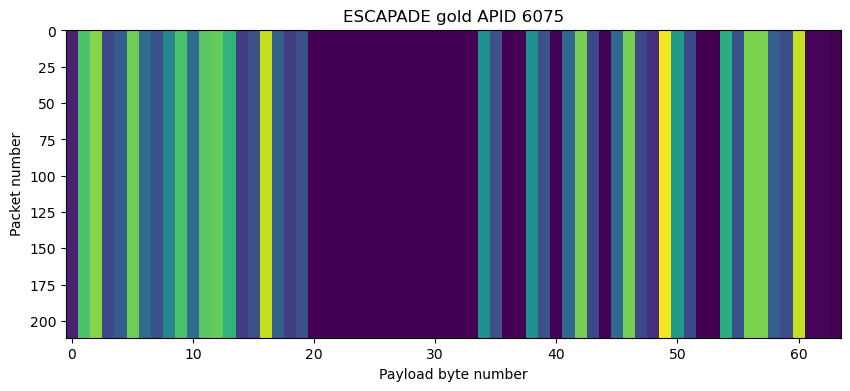

In [73]:
plot_apid('gold', 6075)

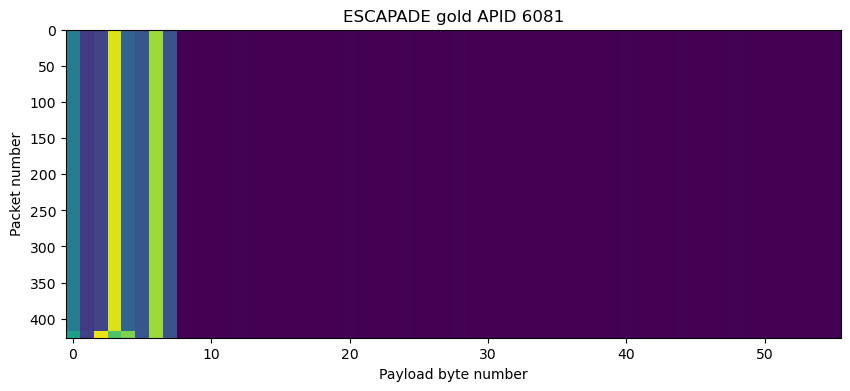

In [74]:
plot_apid('gold', 6081)

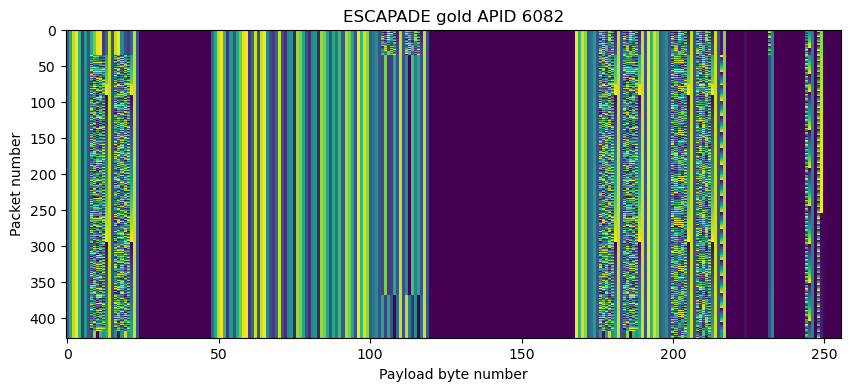

In [75]:
plot_apid('gold', 6082)

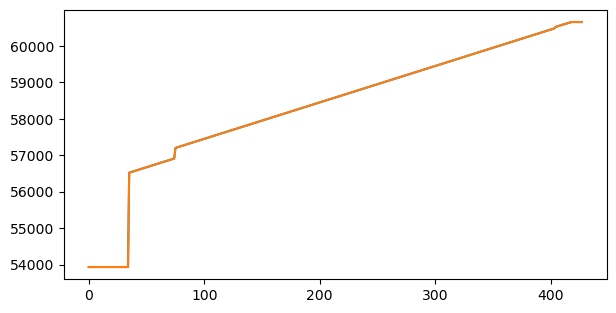

In [76]:
plt.plot(array_by_apid('gold', 6082)[:, 8:24].view('float64'));

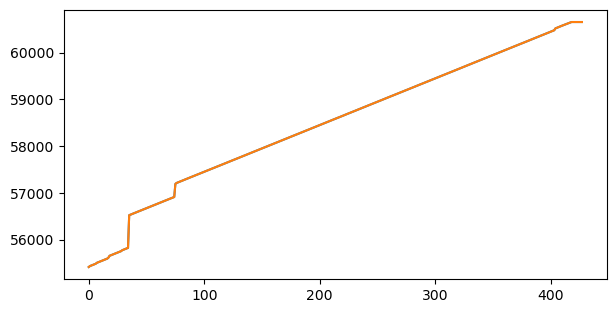

In [77]:
plt.plot(array_by_apid('gold', 6082)[:, 176:192].view('float64'));

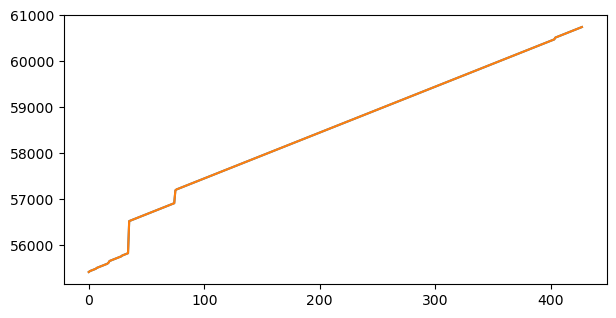

In [78]:
plt.plot(array_by_apid('gold', 6082)[:, 200:216].view('float64'));

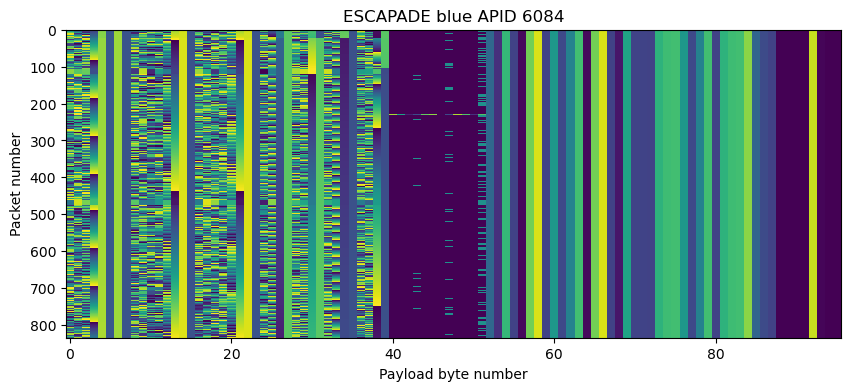

In [79]:
plot_apid('blue', 6084)

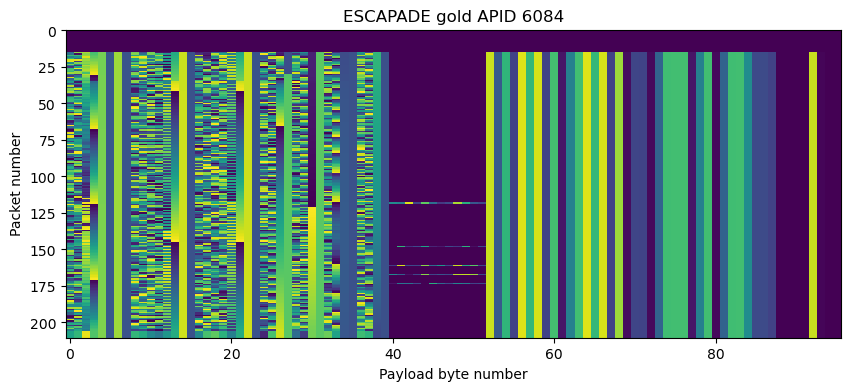

In [80]:
plot_apid('gold', 6084)

In [81]:
t_q_slow = {sc: apid_timestamps[sc][6084] for sc in spacecraft}

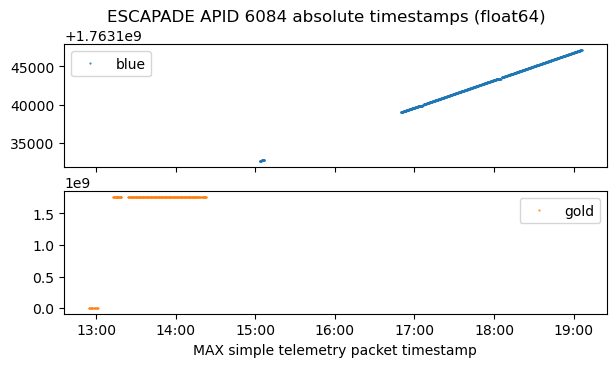

In [82]:
abs_timestamp = {sc: array_by_apid(sc, 6084)[:, :8].view('float64').ravel() for sc in spacecraft}
fig, axs = plt.subplots(2, 1, sharex=True)
for j, sc in enumerate(spacecraft):
    axs[j].plot(t_q_slow[sc], abs_timestamp[sc], '.', markersize=1, color=f'C{j}', label=sc)
    axs[j].legend()
timestamp_axis()
axs[-1].set_xlabel('MAX simple telemetry packet timestamp')
plt.suptitle('ESCAPADE APID 6084 absolute timestamps (float64)', y=0.98);

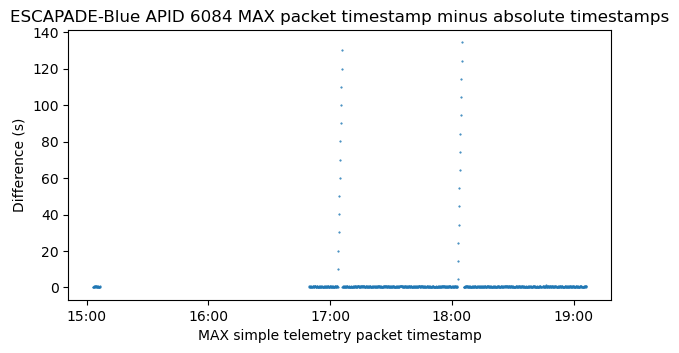

In [83]:
abs_timestamp_datetime64 = {sc: np.datetime64('1970-01-01T00:00:00') + (1e9 * abs_timestamp[sc]) * np.timedelta64(1, 'ns')
                            for sc in spacecraft}
plt.plot(t_q_slow['blue'], (t_q_slow['blue'] - abs_timestamp_datetime64['blue']) / np.timedelta64(1, 's'), '.', markersize=1)
timestamp_axis()
plt.xlabel('MAX simple telemetry packet timestamp')
plt.title('ESCAPADE-Blue APID 6084 MAX packet timestamp minus absolute timestamps')
plt.ylabel('Difference (s)');

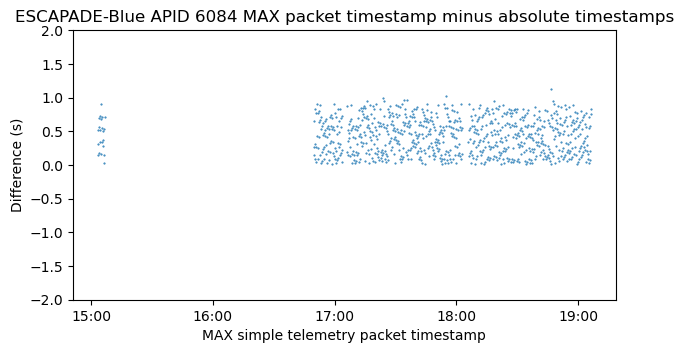

In [84]:
plt.plot(t_q_slow['blue'], (t_q_slow['blue'] - abs_timestamp_datetime64['blue']) / np.timedelta64(1, 's'), '.', markersize=1)
plt.ylim(-2, 2)
timestamp_axis()
plt.xlabel('MAX simple telemetry packet timestamp')
plt.title('ESCAPADE-Blue APID 6084 MAX packet timestamp minus absolute timestamps')
plt.ylabel('Difference (s)');

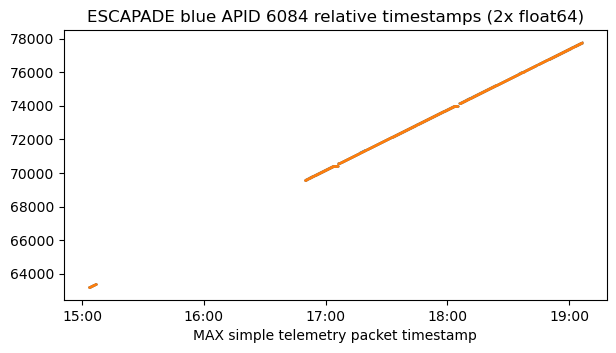

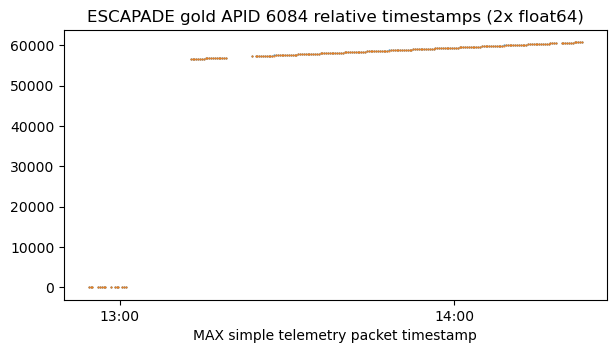

In [85]:
rel_timestamps = {sc: array_by_apid(sc, 6084)[:, 8:24].view('float64') for sc in spacecraft}
for sc in spacecraft:
    plt.figure()
    plt.plot(t_q_slow[sc], rel_timestamps[sc], '.', markersize=1)
    timestamp_axis()
    plt.xlabel('MAX simple telemetry packet timestamp')
    plt.title(f'ESCAPADE {sc} APID 6084 relative timestamps (2x float64)')

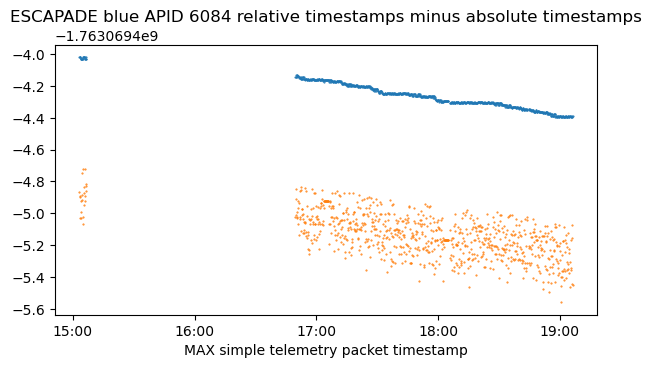

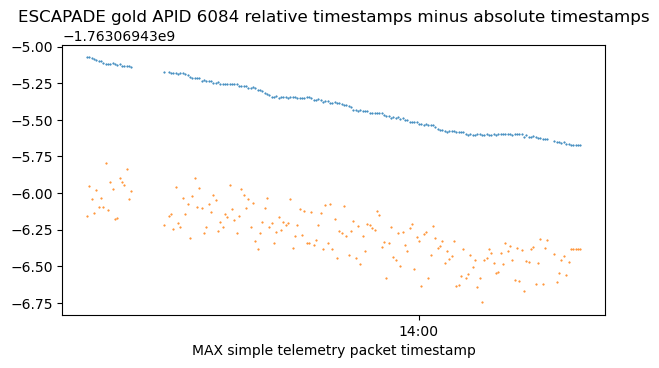

In [86]:
for sc in spacecraft:
    plt.figure()
    tsel = t_q_slow[sc] >= np.datetime64('2025-11-14T13:02')
    plt.plot(t_q_slow[sc][tsel], rel_timestamps[sc][tsel] - abs_timestamp[sc][tsel, np.newaxis], '.', markersize=1)
    timestamp_axis()
    plt.xlabel('MAX simple telemetry packet timestamp')
    plt.title(f'ESCAPADE {sc} APID 6084 relative timestamps minus absolute timestamps')

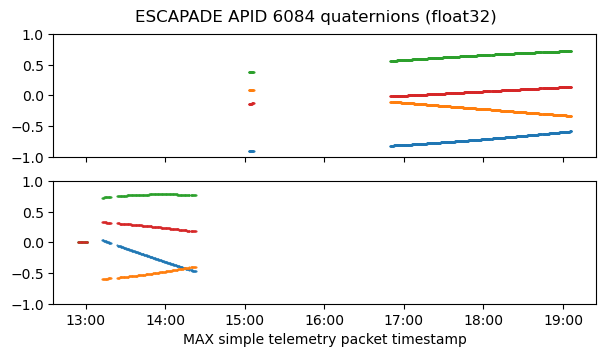

In [87]:
quat_slow = {sc: array_by_apid(sc, 6084)[:, 24:40].view('float32') for sc in spacecraft}

fig, axs = plt.subplots(2, 1, sharex=True)
for j, sc in enumerate(spacecraft):
    axs[j].plot(t_q_slow[sc], quat_slow[sc], '.', markersize=1)
    axs[j].set_ylim(-1, 1)
timestamp_axis()
axs[-1].set_xlabel('MAX simple telemetry packet timestamp')
plt.suptitle('ESCAPADE APID 6084 quaternions (float32)', y=0.95);

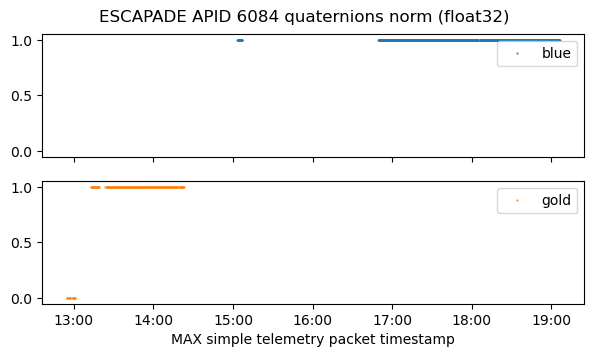

In [88]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
for j, sc in enumerate(spacecraft):
    axs[j].plot(t_q_slow[sc], np.sqrt(np.sum(quat_slow[sc]**2, axis=1)), '.', markersize=1, color=f'C{j}', label=sc)
    axs[j].legend()
timestamp_axis()
axs[-1].set_xlabel('MAX simple telemetry packet timestamp')
plt.suptitle('ESCAPADE APID 6084 quaternions norm (float32)', y=0.95);

/tmp/ipykernel_4852/2673661779.py:9: RuntimeWarning: invalid value encountered in divide
  V_slow[sc] /= np.sqrt(np.sum(V_slow[sc]**2, axis = -1))[..., np.newaxis]


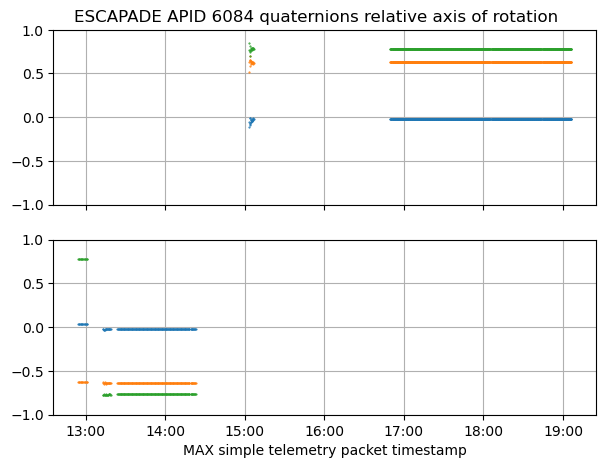

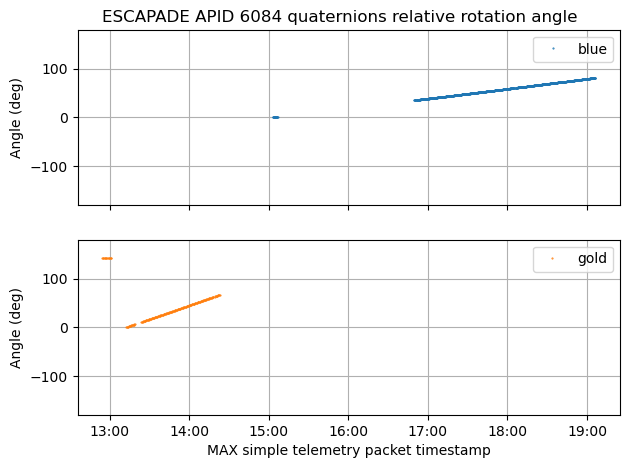

In [89]:
quat_slow_fix = {sc: np.copy(quat_slow[sc]) for sc in spacecraft}
for sc in spacecraft:
    quat_slow_fix[sc][np.all(quat_slow_fix[sc] == 0, axis=1)] = [0, 0, 0, 1]
q_slow = {sc: Rotation.from_quat(quat_slow_fix[sc]) for sc in spacecraft}
q_slow_ref = {'blue': 0, 'gold': 15}
h_slow = {sc: q_slow[sc].inv() * q_slow[sc][q_slow_ref[sc]] for sc in spacecraft}
V_slow = {sc: h_slow[sc].as_quat()[:, :-1] for sc in spacecraft}
for sc in spacecraft:
    V_slow[sc] /= np.sqrt(np.sum(V_slow[sc]**2, axis = -1))[..., np.newaxis]

theta_slow = {sc: 2 * np.arctan2(np.sqrt(np.sum(h_slow[sc].as_quat()[:,:-1]**2, axis = 1)), h_slow[sc].as_quat()[:,-1])
              for sc in spacecraft}
for sc in spacecraft:
    theta_slow[sc] = (theta_slow[sc] + np.pi) % (2 * np.pi) - np.pi

fig, axs = plt.subplots(2, 1, figsize=(7, 5), sharex=True)
for j, sc in enumerate(spacecraft):
    axs[j].plot(t_q_slow[sc], V_slow[sc], '.', markersize=1)
    axs[j].set_ylim(-1, 1)
    axs[j].grid()
timestamp_axis()
plt.xlabel('MAX simple telemetry packet timestamp')
plt.suptitle('ESCAPADE APID 6084 quaternions relative axis of rotation', y=0.92)

fig, axs = plt.subplots(2, 1, figsize=(7, 5), sharex=True)
for j, sc in enumerate(spacecraft):
    axs[j].plot(t_q_slow[sc], np.rad2deg(theta_slow[sc]), '.', markersize=1, color=f'C{j}', label=sc)
    axs[j].legend()
    axs[j].set_ylim(-180, 180)
    axs[j].grid()
    axs[j].set_ylabel('Angle (deg)')
timestamp_axis()
plt.xlabel('MAX simple telemetry packet timestamp')
plt.suptitle('ESCAPADE APID 6084 quaternions relative rotation angle', y=0.92);

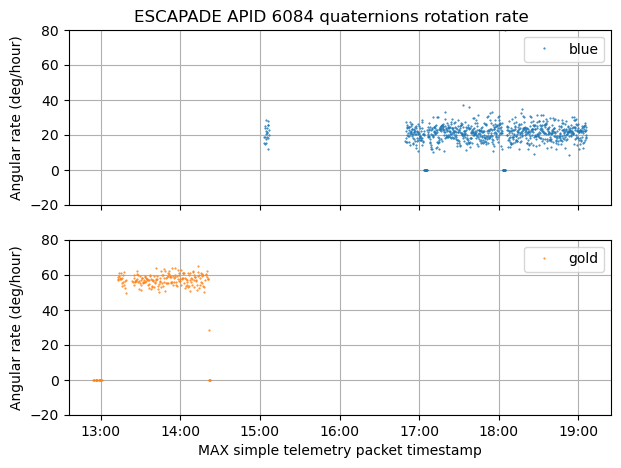

In [90]:
dtq_slow = {sc: np.diff(t_q_slow[sc]) / np.timedelta64(1, 's') for sc in spacecraft}
dq_slow = {sc: q_slow[sc][:-1].inv() * q_slow[sc][1:] for sc in spacecraft}
dtheta_slow = {sc: 2 * np.arctan2(np.sqrt(np.sum(dq_slow[sc].as_quat()[:,:-1]**2, axis = 1)), dq_slow[sc].as_quat()[:,-1]) / dtq_slow[sc]
               for sc in spacecraft}

fig, axs = plt.subplots(2, 1, figsize=(7, 5), sharex=True)
for j, sc in enumerate(spacecraft):
    axs[j].plot(t_q_slow[sc][:-1], np.rad2deg(dtheta_slow[sc]) * 3600, '.', markersize=1, color=f'C{j}', label=sc)
    axs[j].legend()
    axs[j].set_ylim(-20, 80)
    axs[j].grid()
    axs[j].set_ylabel('Angular rate (deg/hour)')
timestamp_axis()
plt.xlabel('MAX simple telemetry packet timestamp')
plt.suptitle('ESCAPADE APID 6084 quaternions rotation rate', y=0.92);

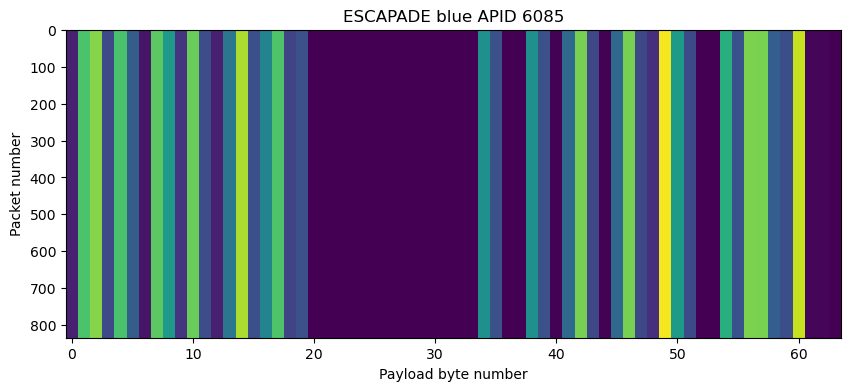

In [91]:
plot_apid('blue', 6085)

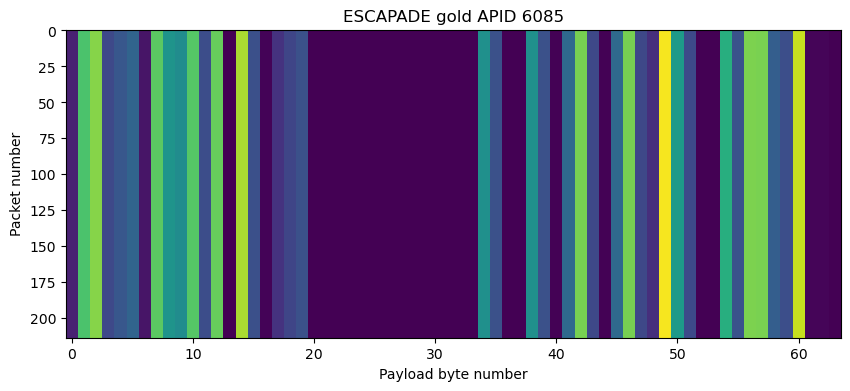

In [92]:
plot_apid('gold', 6085)

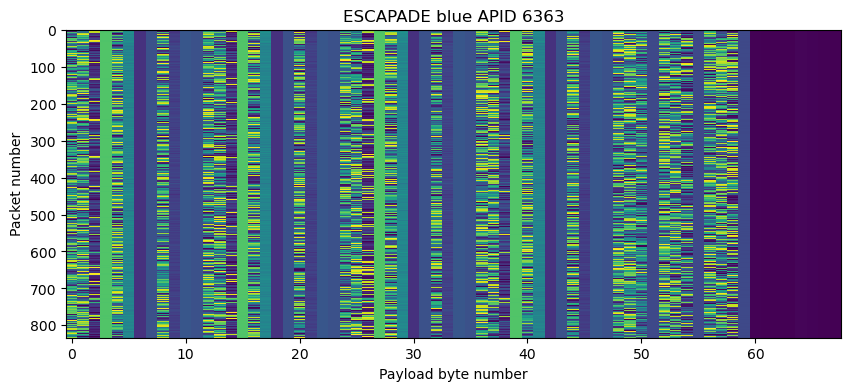

In [93]:
plot_apid('blue', 6363)

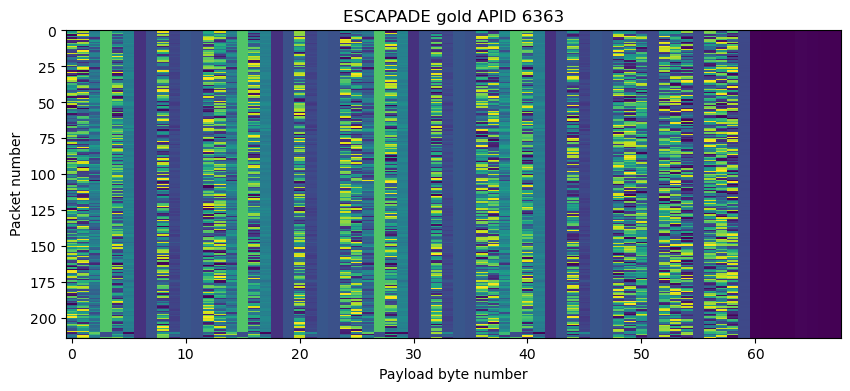

In [94]:
plot_apid('gold', 6363)

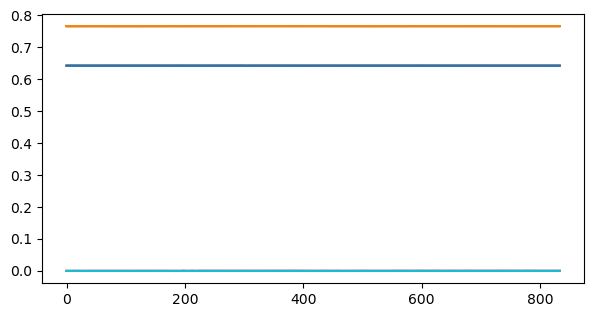

In [95]:
float_channels = array_by_apid('blue', 6363)[:, :48].view('float32')
plt.plot(float_channels);

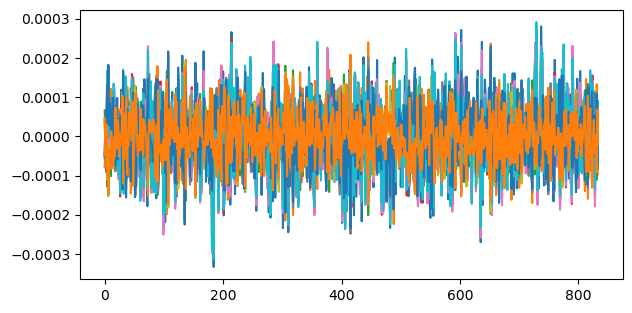

In [96]:
plt.plot(float_channels - np.average(float_channels, axis=0));

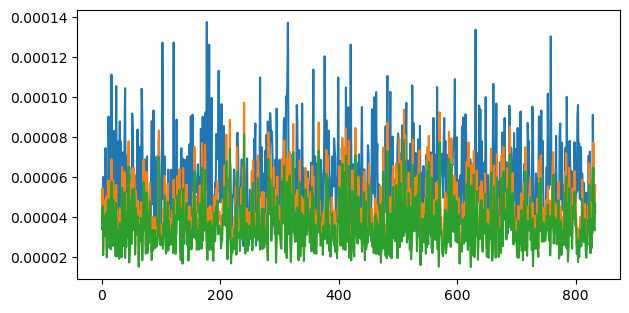

In [97]:
plt.plot(array_by_apid('blue', 6363)[:, 48:60].view('float32'));

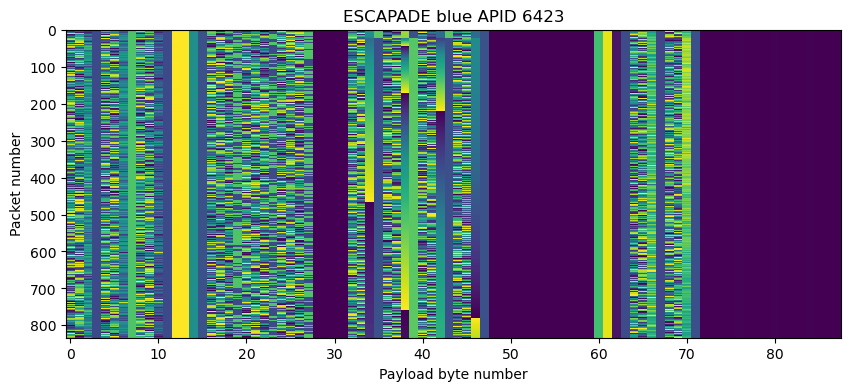

In [98]:
plot_apid('blue', 6423)

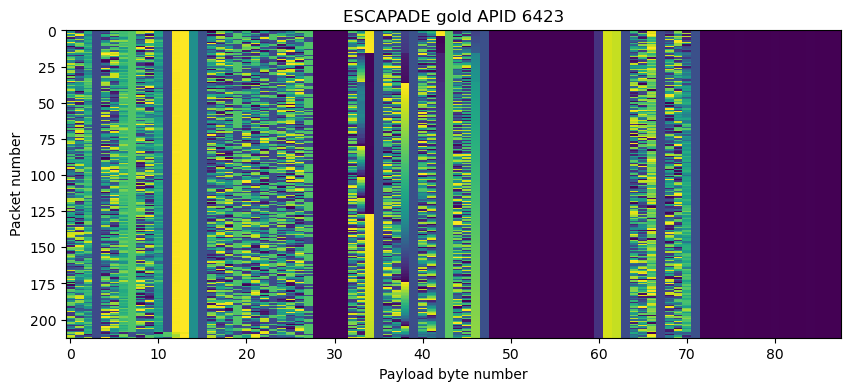

In [99]:
plot_apid('gold', 6423)

In [100]:
t_q  = {sc: apid_timestamps[sc][6423] for sc in spacecraft}

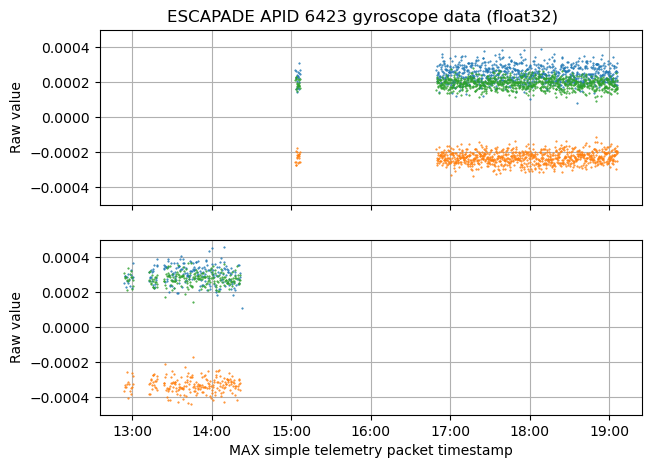

In [101]:
gyros = {sc: array_by_apid(sc, 6423)[:, :12].view('float32') for sc in spacecraft}

fig, axs = plt.subplots(2, 1, figsize=(7, 5), sharex=True)
for j, sc in enumerate(spacecraft):
    axs[j].plot(t_q[sc], gyros[sc], '.', markersize=1)
    axs[j].set_ylim(-5e-4, 5e-4)
    axs[j].grid()
    axs[j].set_ylabel('Raw value')
timestamp_axis()
plt.xlabel('MAX simple telemetry packet timestamp')
plt.suptitle('ESCAPADE APID 6423 gyroscope data (float32)', y=0.92);

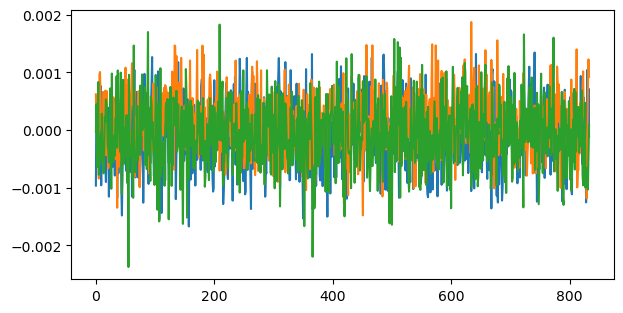

In [102]:
plt.plot(array_by_apid('blue', 6423)[:, 16:28].view('float32'));

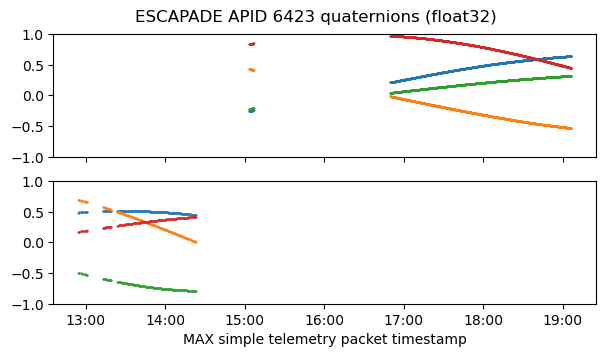

In [103]:
quat = {sc: array_by_apid(sc, 6423)[:, 32:48].view('float32') for sc in spacecraft}

fig, axs = plt.subplots(2, 1, sharex=True)
for j, sc in enumerate(spacecraft):
    axs[j].plot(t_q[sc], quat[sc], '.', markersize=1)
    axs[j].set_ylim(-1, 1)
timestamp_axis()
axs[-1].set_xlabel('MAX simple telemetry packet timestamp')
plt.suptitle('ESCAPADE APID 6423 quaternions (float32)', y=0.95);

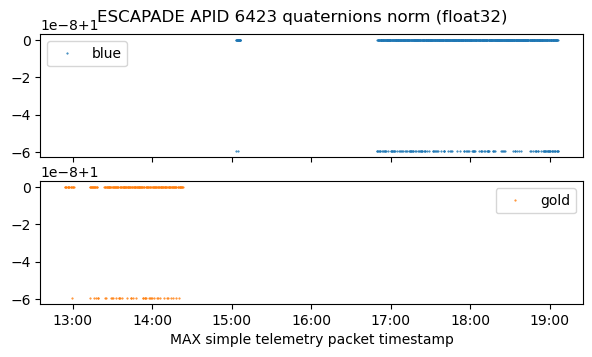

In [104]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
for j, sc in enumerate(spacecraft):
    axs[j].plot(t_q[sc], np.sqrt(np.sum(quat[sc]**2, axis=1)), '.', markersize=1, color=f'C{j}', label=sc)
    axs[j].legend()
timestamp_axis()
axs[-1].set_xlabel('MAX simple telemetry packet timestamp')
plt.suptitle('ESCAPADE APID 6423 quaternions norm (float32)', y=0.95);

/tmp/ipykernel_4852/2372017084.py:5: RuntimeWarning: invalid value encountered in divide
  V[sc] /= np.sqrt(np.sum(V[sc]**2, axis = -1))[..., np.newaxis]


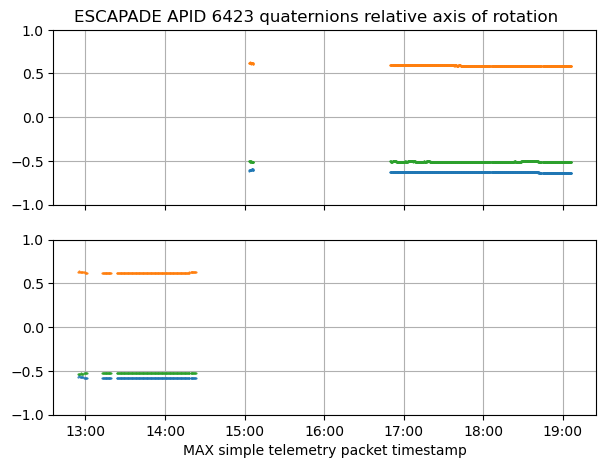

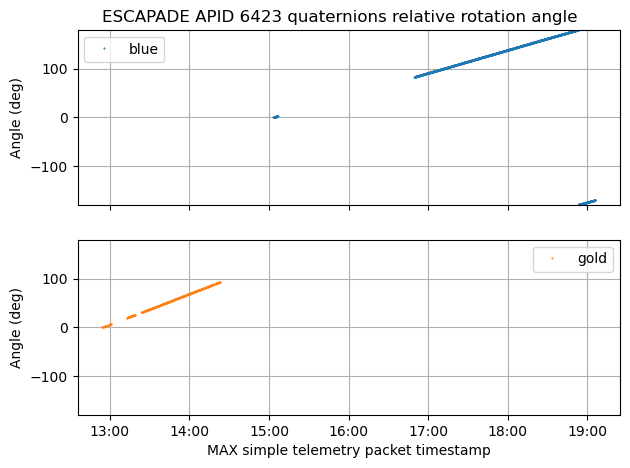

In [105]:
q = {sc: Rotation.from_quat(quat[sc]) for sc in spacecraft}
h = {sc: q[sc].inv() * q[sc][0] for sc in spacecraft}
V = {sc: h[sc].as_quat()[:, :-1] for sc in spacecraft}
for sc in spacecraft:
    V[sc] /= np.sqrt(np.sum(V[sc]**2, axis = -1))[..., np.newaxis]

theta = {sc: 2 * np.arctan2(np.sqrt(np.sum(h[sc].as_quat()[:,:-1]**2, axis = 1)), h[sc].as_quat()[:,-1]) for sc in spacecraft}
theta = {sc: (theta[sc] + np.pi) % (2 * np.pi) - np.pi for sc in spacecraft}

fig, axs = plt.subplots(2, 1, figsize=(7, 5), sharex=True)
for j, sc in enumerate(spacecraft):
    axs[j].plot(t_q[sc], V[sc], '.', markersize=1)
    axs[j].set_ylim(-1, 1)
    axs[j].grid()
timestamp_axis()
plt.xlabel('MAX simple telemetry packet timestamp')
plt.suptitle('ESCAPADE APID 6423 quaternions relative axis of rotation', y=0.92)

fig, axs = plt.subplots(2, 1, figsize=(7, 5), sharex=True)
for j, sc in enumerate(spacecraft):
    axs[j].plot(t_q[sc], np.rad2deg(theta[sc]), '.', markersize=1, color=f'C{j}', label=sc)
    axs[j].legend()
    axs[j].set_ylim(-180, 180)
    axs[j].grid()
    axs[j].set_ylabel('Angle (deg)')
timestamp_axis()
plt.xlabel('MAX simple telemetry packet timestamp')
plt.suptitle('ESCAPADE APID 6423 quaternions relative rotation angle', y=0.92);

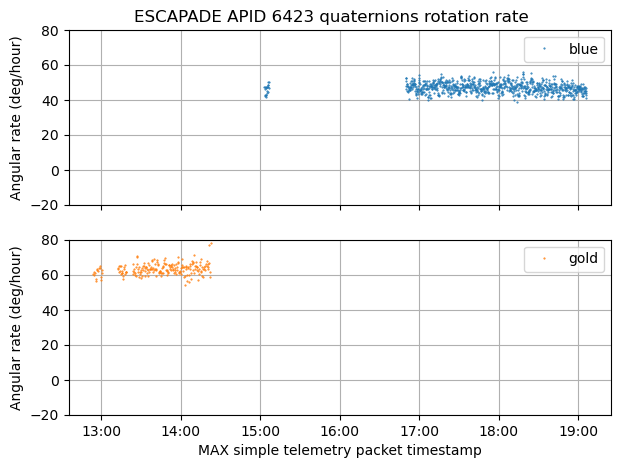

In [106]:
dtq = {sc: np.diff(t_q[sc]) / np.timedelta64(1, 's') for sc in spacecraft}
dq = {sc: q[sc][:-1].inv() * q[sc][1:] for sc in spacecraft}
dtheta = {sc: 2 * np.arctan2(np.sqrt(np.sum(dq[sc].as_quat()[:,:-1]**2, axis = 1)), dq[sc].as_quat()[:,-1]) / dtq[sc]
          for sc in spacecraft}

fig, axs = plt.subplots(2, 1, figsize=(7, 5), sharex=True)
for j, sc in enumerate(spacecraft):
    axs[j].plot(t_q[sc][:-1], np.rad2deg(dtheta[sc]) * 3600, '.', markersize=1, color=f'C{j}', label=sc)
    axs[j].legend()
    axs[j].set_ylim(-20, 80)
    axs[j].grid()
    axs[j].set_ylabel('Angular rate (deg/hour)')
timestamp_axis()
plt.xlabel('MAX simple telemetry packet timestamp')
plt.suptitle('ESCAPADE APID 6423 quaternions rotation rate', y=0.92);

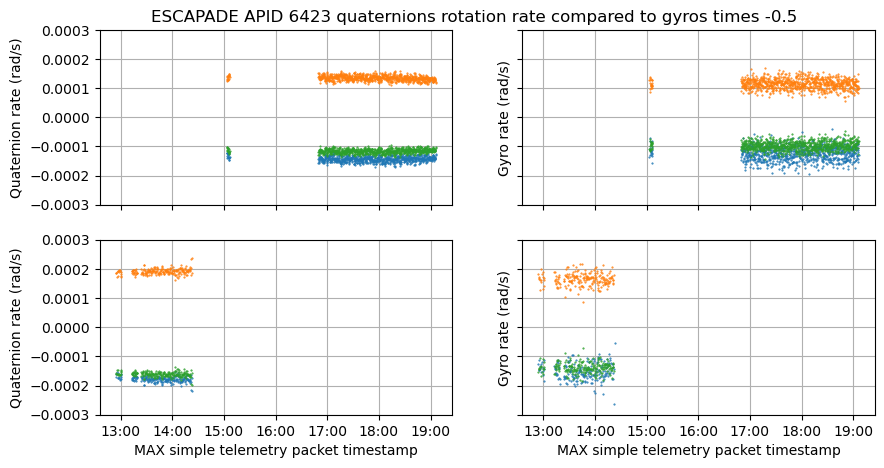

In [107]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharex=True, sharey=True)
for j, sc in enumerate(spacecraft):
    axs[j, 0].plot(t_q[sc][:-1], dtheta[sc][:, np.newaxis] * V[sc][:-1], '.', markersize=1)
    axs[j, 1].plot(t_q[sc], -0.5 * gyros[sc], '.', markersize=1)
    axs[j, 0].set_ylabel('Quaternion rate (rad/s)')
    axs[j, 1].set_ylabel('Gyro rate (rad/s)')
for ax in axs.ravel():
    ax.set_ylim(-3e-4, 3e-4)
    ax.grid()
timestamp_axis()
for ax in axs[-1]:
    ax.set_xlabel('MAX simple telemetry packet timestamp')
plt.suptitle('ESCAPADE APID 6423 quaternions rotation rate compared to gyros times -0.5', y=0.92);

In [108]:
ids = {'blue': 'ESCAPADE-Blue', 'gold': 'ESCAPADE-Gold'}
state_vectors = {sc: Horizons(
    id=ids[sc], location='Hat Creek Observatory (Allen Array)',
    epochs={'start': '2025-11-14T12:00:00', 'stop': '2025-11-14T19:30:00', 'step': '27000'}).vectors()
                 for sc in spacecraft}

In [109]:
state_vectors_t = {sc: Time(state_vectors[sc]['datetime_jd'], format='jd', scale='utc').datetime64
                   for sc in spacecraft}
r_ata = {sc: np.array([state_vectors[sc][xyz].to(u.km).value for xyz in 'xyz']).T
         for sc in spacecraft}
r_ata_interp = {sc: np.array([
    np.interp((t_q[sc] - state_vectors_t[sc][0]) / np.timedelta64(1, 'ns'),
              (state_vectors_t[sc] - state_vectors_t[sc][0]) / np.timedelta64(1, 'ns'),
              r_ata[sc][:, j])
    for j in range(3)]).T
                for sc in spacecraft}

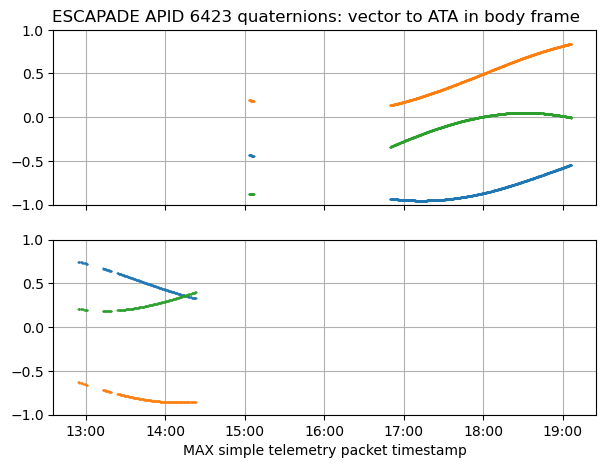

In [110]:
fig, axs = plt.subplots(2, 1, figsize=(7, 5), sharex=True)
for j, sc in enumerate(spacecraft):
    axs[j].plot(t_q[sc], q[sc].inv().apply(r_ata_interp[sc] / np.sqrt(np.sum(r_ata_interp[sc]**2, axis=1))[:, np.newaxis]),
                '.', markersize=1)
    axs[j].set_ylim(-1, 1)
    axs[j].grid()
timestamp_axis()
plt.xlabel('MAX simple telemetry packet timestamp')
plt.suptitle('ESCAPADE APID 6423 quaternions: vector to ATA in body frame', y=0.92);

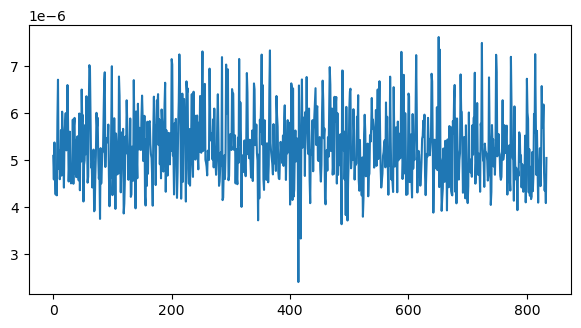

In [111]:
plt.plot(array_by_apid('blue', 6423)[:, 64:68].view('float32'));

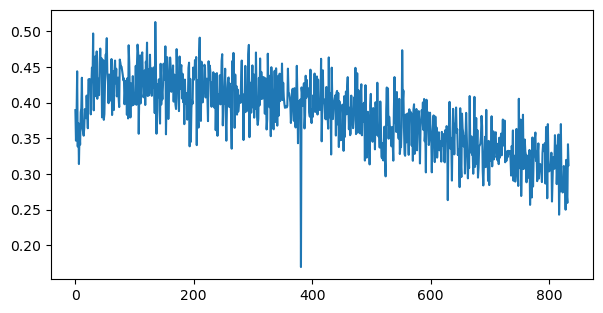

In [112]:
plt.plot(array_by_apid('blue', 6423)[:, 68:72].view('float32'));

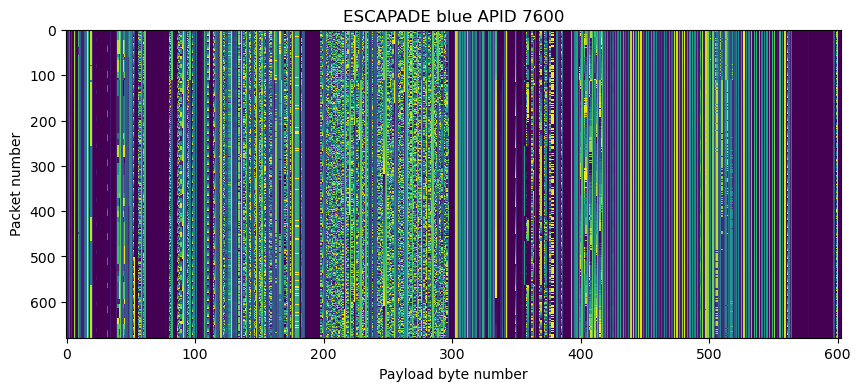

In [113]:
plot_apid('blue', 7600)

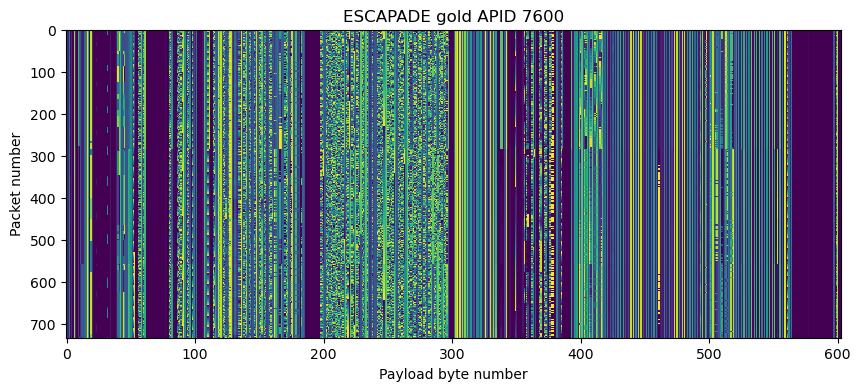

In [114]:
plot_apid('gold', 7600)

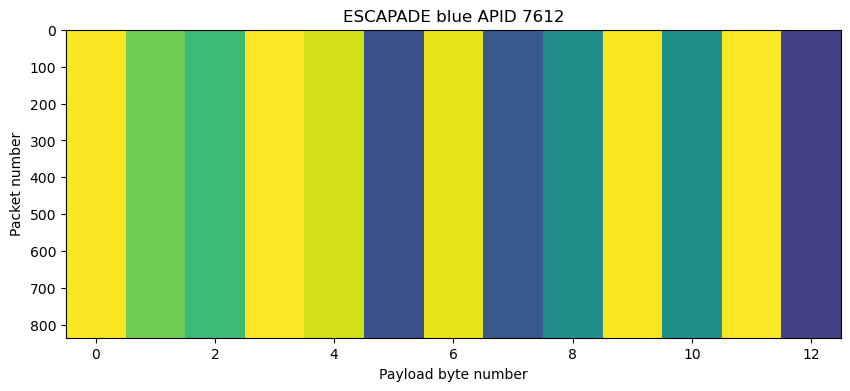

In [115]:
plot_apid('blue', 7612)

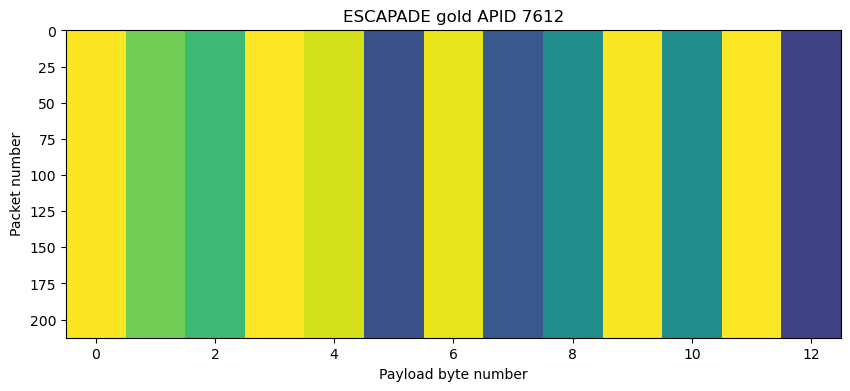

In [116]:
plot_apid('gold', 7612)

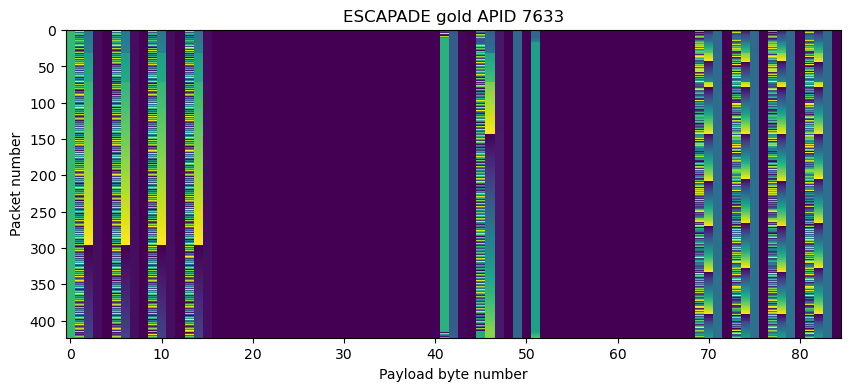

In [117]:
plot_apid('gold', 7633)

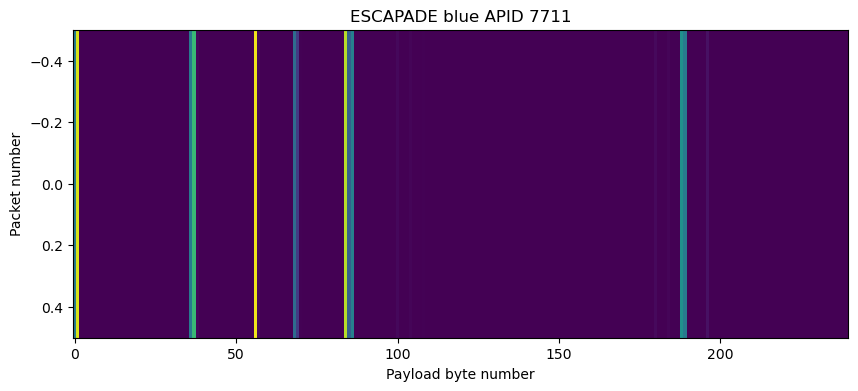

In [118]:
plot_apid('blue', 7711)

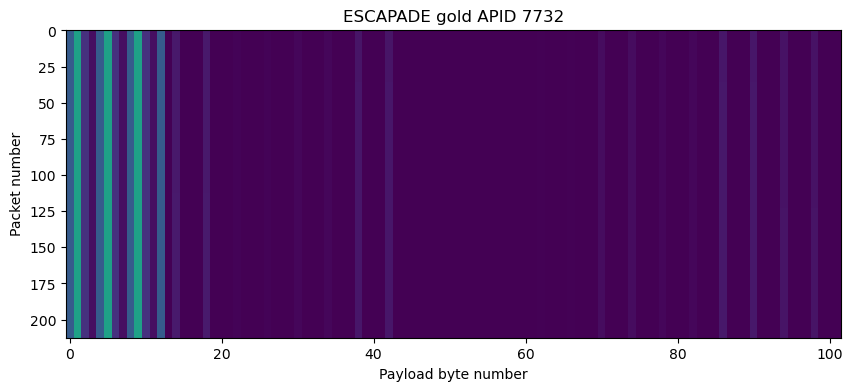

In [119]:
plot_apid('gold', 7732)

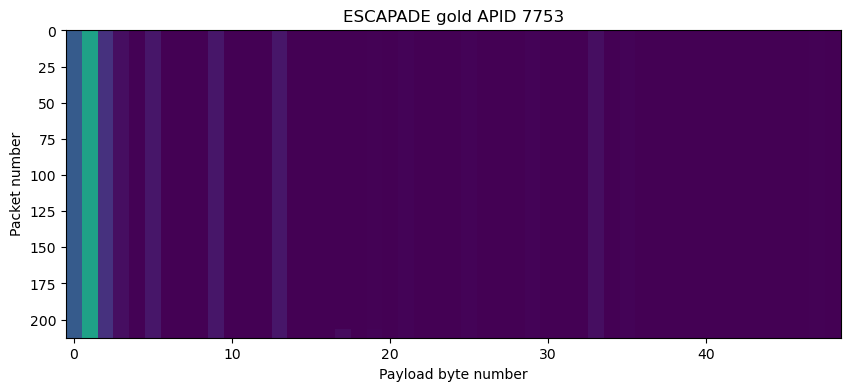

In [120]:
plot_apid('gold', 7753)

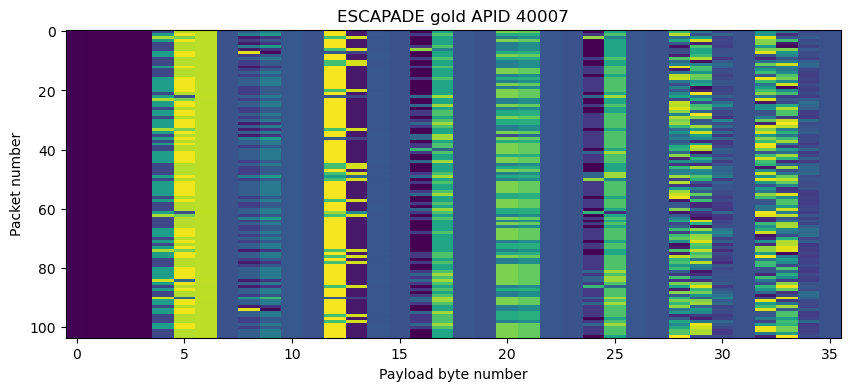

In [121]:
plot_apid('gold', 40007)